# 0.0. IMPORTS

## 0.1. Import Frameworks

In [150]:
# manipulation
import pandas as pd
import numpy as np
import inflection
from IPython.display       import Image
from scipy                   import stats             as ss
import warnings

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from boruta                  import BorutaPy
import sklearn.ensemble as en
from lightgbm import LGBMClassifier
import xgboost
from sklearn.feature_selection import RFE
from sklearn import linear_model as lm
from sklearn                 import neighbors         as nhb
from sklearn                 import naive_bayes       as nb
import catboost                                       as cb
from sklearn import model_selection as ms
from sklearn import metrics as met
from imblearn.over_sampling  import SMOTE
from imblearn.under_sampling  import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
import scikitplot as skplot

## 0.2. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    pd.options.mode.chained_assignment = None 
    
    sns.set()
    
# Plot categorical attributes with annot
def plot_cat(att, annot=True):
    
    splot = sns.countplot(x = att)
    total = 0
    if annot == True:
        for p in splot.patches:
            total += p.get_height()
            
        for p in splot.patches:
            splot.annotate(format(p.get_height()/total, '.4f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

# Plot histogram and boxplot to univariate analysis
def plot_dist(att, bins='auto', title=None):
    grid = plt.GridSpec(2, 1)

    plt.subplot(grid[0, 0])
    sns.histplot(x = att, bins=bins)
    plt.title(title)

    plt.subplot(grid[1, 0])
    sns.boxplot(x = att)
    

# Func to cramer_v
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]

    chi2corr = max(0, chi2 - (k - 1)*(r - 1)/(n - 1))
    kcorr = k - (k - 1)**2/(n - 1)
    rcorr = r - (r - 1)**2/(n - 1)
    
    return np.sqrt((chi2corr/n) / (min( kcorr-1, rcorr-1)))

def tune_cv(X, y, n_splits, random_state, threshold, max_eval):
    all_it = {}
    cont = 0
    
    for i in range(max_eval):
        hp = {k: np.random.choice( v, 1 )[0] for k, v in space.items()}
        model = LGBMClassifier(learning_rate=hp['learning_rate'],
                               num_leaves=hp['num_leaves'],
                               min_child_samples=hp['min_child_samples'],
                               min_child_weight=hp['min_child_weight'],
                               subsample=hp['subsample'],
                               colsample_bytree=hp['colsample_bytree'],
                               random_state=random_state, subsample_freq=1,
                               n_estimators=100)
        kf = ms.StratifiedKFold(n_splits=n_splits)
        
        mean_roc_auc = []
        for train_index, valid_index in kf.split(X, y):
            X_train = X.iloc[train_index, :]
            y_train = y.iloc[train_index]
            
            # defines the resampler
            resampler_smotetomek = SMOTETomek(random_state=random_state, n_jobs=-1)

            # makes the balancing
            X_balanced, y_balanced = resampler_smotetomek.fit_resample(X_train, y_train)
            
            X_valid = X.iloc[valid_index, :]
            y_valid = y.iloc[valid_index]

            model.fit(X_balanced.values, y_balanced.values.ravel())

            y_proba = model.predict_proba(X_valid)[:, 1]
            y_hat = (y_proba >= threshold).astype(int)

            mean_roc_auc.append(met.roc_auc_score(y_valid, y_proba))
        
        h = pd.DataFrame({'roc_auc': np.mean(mean_roc_auc),
                          'learning_rate': hp['learning_rate'],
                          'num_leaves': hp['num_leaves'],
                          'min_child_samples': hp['min_child_samples'],
                          'min_child_weight': hp['min_child_weight'],
                          'subsample': hp['subsample'],
                          'colsample_bytree': hp['colsample_bytree']}, index=[cont + 1])
        
        if cont != 0:
            df = pd.concat([df, h])
        else:
            df = h
        cont += 1
        
    return df.sort_values(by='roc_auc', ascending=False)

###################################################################


class PerformanceView:
    
    def __init__(self, model, X, y, n_splits, threshold):
        # parameters initialize
        self.model = model
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.threshold = threshold
        # params
        self.all_confusion_matrix = None
        self.all_proba = None
        self.all_auc = None
        self.final_df = None
        self.fpr_mean = np.linspace(0, 1, 10000)
    
    def performance(self, oversample=False, random_state = None):
        # trains models and saves performances of cross-validation
        kf = ms.StratifiedKFold(n_splits=self.n_splits)
        i = 0
        fpr_mean = np.linspace(0, 1, 10000)
        all_confusion_matrix = {} # matrix with each confusion matrix model
        all_proba = {} # concat all probabilities for fold for each model
        all_auc = {} # list of all auc for each model
        
        for m in self.model: # for model
            j = 0
            print('Training ' + type(m).__name__ + '...')
            
            # lists of metrics
            list_accuracy = []
            list_precision = []
            list_recall = []
            list_f1 = []
            list_kappa = []
            list_roc_auc = []
            list_conf_mat = []
            tprs = []

            for train_index, valid_index in kf.split(self.X, self.y): # split dataset train - valid
                # train
                X_train = self.X.iloc[train_index, :]
                y_train = self.y.iloc[train_index]
                
                if oversample:
                    # defines the resampler
                    resampler_smotetomek = SMOTETomek(n_jobs=-1)

                    # makes the balancing
                    X_balanced, y_balanced = resampler_smotetomek.fit_resample(X_train, y_train)
                
                
                # valid
                X_valid = self.X.iloc[valid_index, :]
                y_valid = self.y.iloc[valid_index]
                
                # fit model
                m.fit(X_balanced.values, y_balanced.values.ravel())
                
                # probas
                y_proba = m.predict_proba(X_valid)[:, 1]
                y_hat = (y_proba > self.threshold).astype(int)

                # metrics
                # accuracy
                accuracy = met.accuracy_score(y_valid, y_hat)
                list_accuracy.append(accuracy)     
                # precision
                precision = met.precision_score(y_valid, y_hat)
                list_precision.append(precision)
                # recall
                recall = met.recall_score(y_valid, y_hat)
                list_recall.append(recall)
                # f1 score
                f1 = met.f1_score(y_valid, y_hat)
                list_f1.append(f1)
                # kappa score
                kappa = met.cohen_kappa_score(y_valid, y_hat)
                list_kappa.append(kappa)
                # roc_auc score
                roc_auc = met.roc_auc_score(y_valid, y_proba)
                list_roc_auc.append(roc_auc)
                
                # create a confusion matrix of fold
                conf_mat = met.confusion_matrix(y_valid, y_hat)
                if j == 0:
                    mat = conf_mat
                else:
                    mat += conf_mat

                # list probas
                if j != 0:
                    all_array = np.concatenate((all_array, y_proba))
                else:
                    all_array = y_proba

                # list roc
                fpr, tpr, _ = met.roc_curve(y_valid, y_proba)
                interp_tpr = np.interp(fpr_mean, fpr, tpr)
                tprs.append(interp_tpr) 

                j += 1
            
            # create dataframe of performance
            final_accuracy = "{:.4f} +/- {:.4f}".format(np.mean(list_accuracy), 2*np.std(list_accuracy))
            final_precision = "{:.4f} +/- {:.4f}".format(np.mean(list_precision), 2*np.std(list_precision))
            final_recall = "{:.4f} +/- {:.4f}".format(np.mean(list_recall), 2*np.std(list_recall))
            final_f1 = "{:.4f} +/- {:.4f}".format(np.mean(list_f1), 2*np.std(list_f1))
            final_kappa = "{:.4f} +/- {:.4f}".format(np.mean(list_kappa), 2*np.std(list_kappa))
            final_roc_auc = "{:.4f} +/- {:.4f}".format(np.mean(list_roc_auc), 2*np.std(list_roc_auc))
            
            df = pd.DataFrame({'accuracy': final_accuracy, 'precision': final_precision, 'recall': final_recall, 
                               'f1': final_f1, 'kappa': final_kappa, 'roc_auc': final_roc_auc}, index=[type(m).__name__])
            if i != 0:
                final_df = pd.concat([final_df, df])
            else:
                final_df = df
                
            # append in dict of confusion_matrix
            all_confusion_matrix[type(m).__name__] = mat

            # append in dict of probas
            all_proba[type(m).__name__] = all_array

            # teste
            all_auc[type(m).__name__] = np.mean(tprs, axis=0)
            
            i += 1
        
        self.all_confusion_matrix = all_confusion_matrix
        self.all_proba = all_proba
        self.all_auc = all_auc
        self.final_df = final_df
    
    
    def df_performance(self):
        return self.final_df
    
    
    def plot_cm(self, n_rows, n_cols):
        h=0
        plt.figure(figsize=(15, 12))

        for keys, value in enumerate(self.all_confusion_matrix):
            h += 1

            plt.subplot(n_rows, n_cols, h)
            sns.heatmap(self.all_confusion_matrix[value], annot=True, cmap='viridis',
                        fmt='g', square=True, annot_kws={"size": 12})

            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title(list(self.all_confusion_matrix)[h- 1])

        plt.subplots_adjust(hspace=0.5)
        
        
    def plot_probas(self, models=None):
        if models:
            for key, value in self.all_proba.items():
                if key in models:
                    sns.kdeplot(value, label=key)
        else:
            for key, value in self.all_proba.items():
                sns.kdeplot(value, label=key)
        plt.legend()
        
        
    def plot_auc(self, models=None):
        if models:
            for key, value in self.all_auc.items():
                if key in models:
                    plt.plot(self.fpr_mean, value, label=key)
        else:
            for key, value in self.all_auc.items():
                plt.plot(self.fpr_mean, value, label=key)
                
        plt.plot([0, 1], [0, 1], 'k--', label='None')
        plt.legend()
        plt.title("ROC Curve", fontsize=14)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

In [3]:
jupyter_settings()

## 0.3. Import Data

In [4]:
# data url
url = 'https://raw.githubusercontent.com/tadeucbm/churn_predict/main/data/churn.csv'

# df is data
df = pd.read_csv(url).drop(['RowNumber', 'CustomerId'], axis=1)

In [5]:
# show df
df.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 1.0. DATA DESCRIPTION

In [6]:
# copy df to next section
df1 = df.copy()

## 1.1. Rename Columns

In [7]:
# select columns
cols_old = df1.columns.to_list()

# anonymous function to underscore columns
snakecase = lambda x: inflection.underscore(x)

# create new column names
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

In [8]:
# print columns
df1.columns

Index(['surname', 'credit_score', 'geography', 'gender', 'age', 'tenure',
       'balance', 'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

## 1.2. Data Dimension

In [9]:
# print the number of rows
print(f'Number of rows: {df1.shape[0]}')

# print the number of columns
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 10000
Number of columns: 12


## 1.3. Data Types

In [10]:
# view dtypes
df1.dtypes

surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

In [11]:
# turning binary variables into objects
df1 = df1.astype({'num_of_products': 'object', 'has_cr_card': 'object', 
                  'is_active_member': 'object', 'exited': 'object', 
                  'tenure': 'object'})

## 1.4. Check NA

In [12]:
# check na values
df1.isna().sum()

surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5. Descriptive Statistics

In [13]:
# df with only numerical attributes
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# df with only categorical attributes
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.5.1. Numerical Attributes

In [14]:
# Central Tendency
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,credit_score,350.00,850.00,500.00,650.528800,652.000,96.648466,-0.071607,-0.425726
1,age,18.00,92.00,74.00,38.921800,37.000,10.487282,1.011320,1.395347
2,balance,0.00,250898.09,250898.09,76485.889288,97198.540,62394.285254,-0.141109,-1.489412
3,estimated_salary,11.58,199992.48,199980.90,100090.239881,100193.915,57507.617221,0.002085,-1.181518


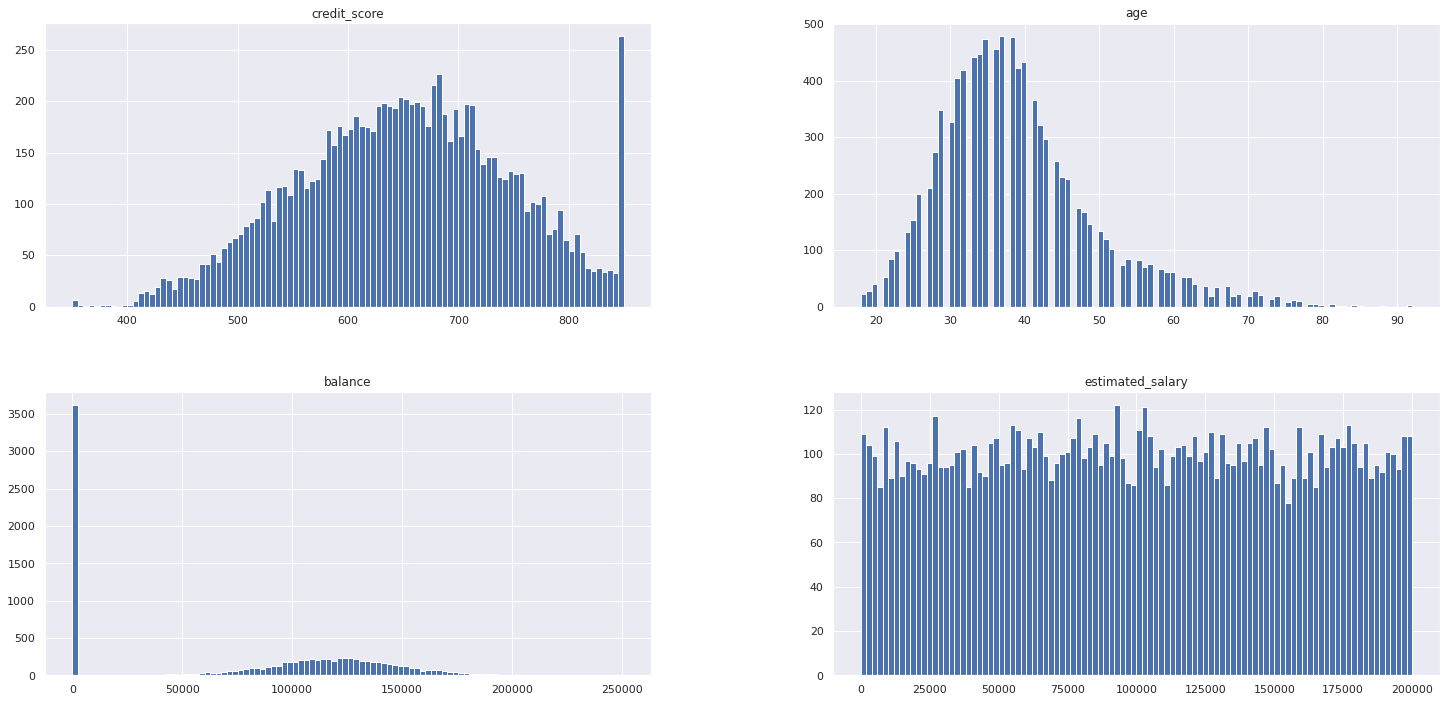

In [15]:
# plot histograms
num_attributes.hist(bins=100);

### 1.5.2. Categorical Attributes

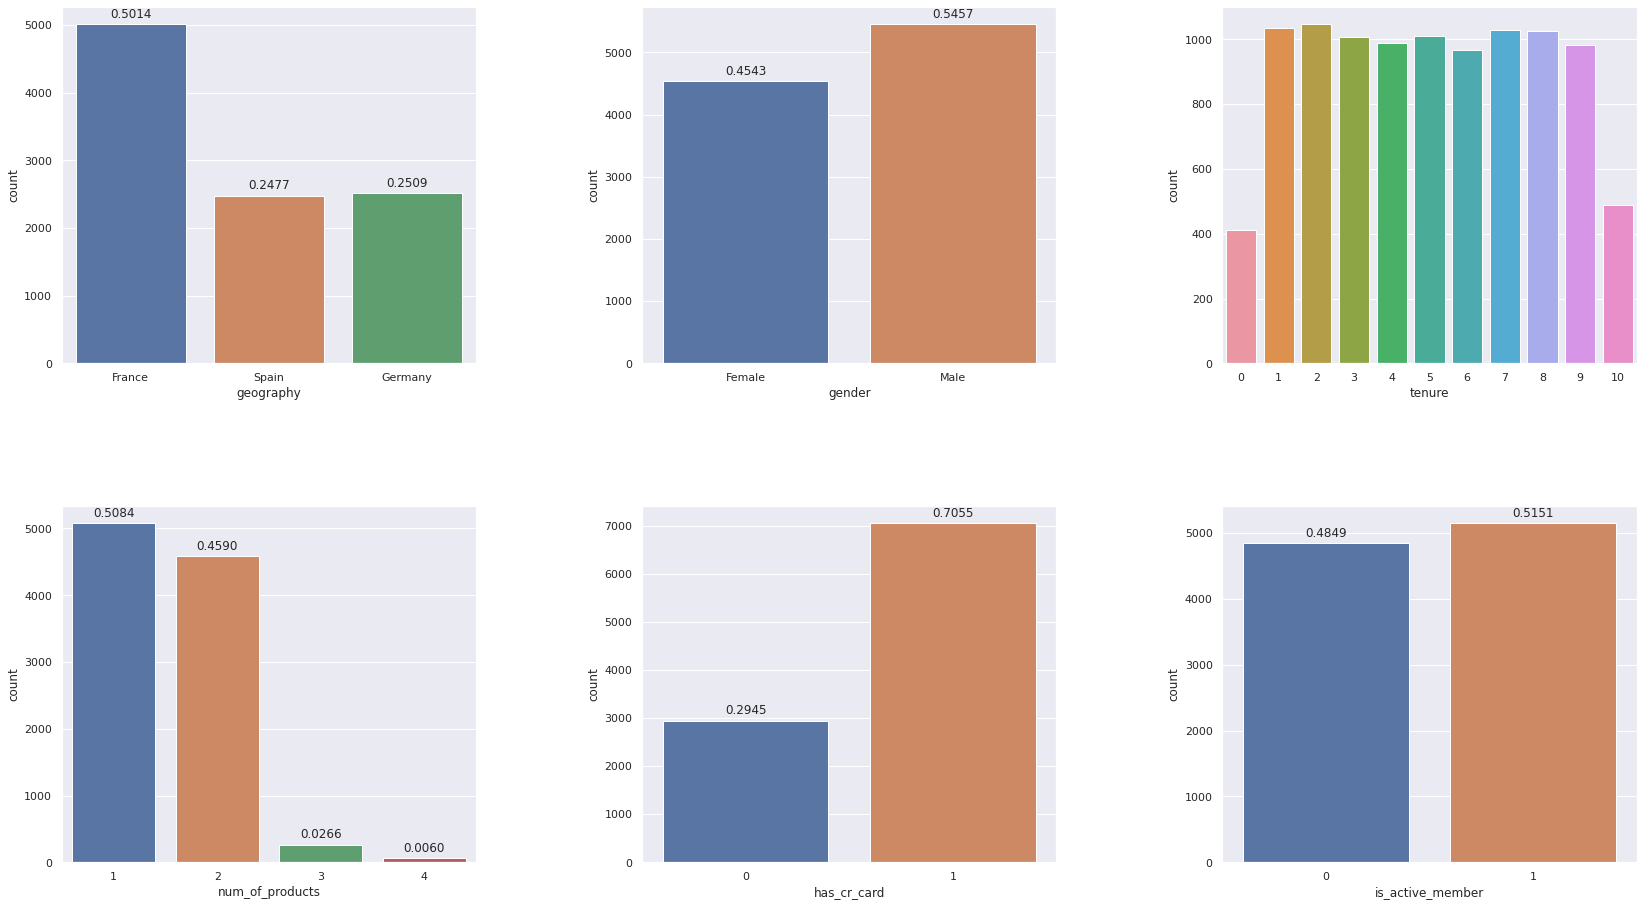

In [16]:
# create grid
grid = plt.GridSpec(2, 3)

# print countplot geography
plt.subplot(grid[0, 0])
plot_cat(cat_attributes['geography'])

# print countplot gender
plt.subplot(grid[0, 1])
plot_cat(cat_attributes['gender'])

# print countplot tenure
plt.subplot(grid[0, 2])
plot_cat(cat_attributes['tenure'], annot=False)

# print countplot num_of_products
plt.subplot(grid[1, 0])
plot_cat(cat_attributes['num_of_products'])

# print countplot has_cr_card
plt.subplot(grid[1, 1])
plot_cat(cat_attributes['has_cr_card'])

# print countplot is_active_member
plt.subplot(grid[1, 2])
plot_cat(cat_attributes['is_active_member'])

plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=1, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.40)

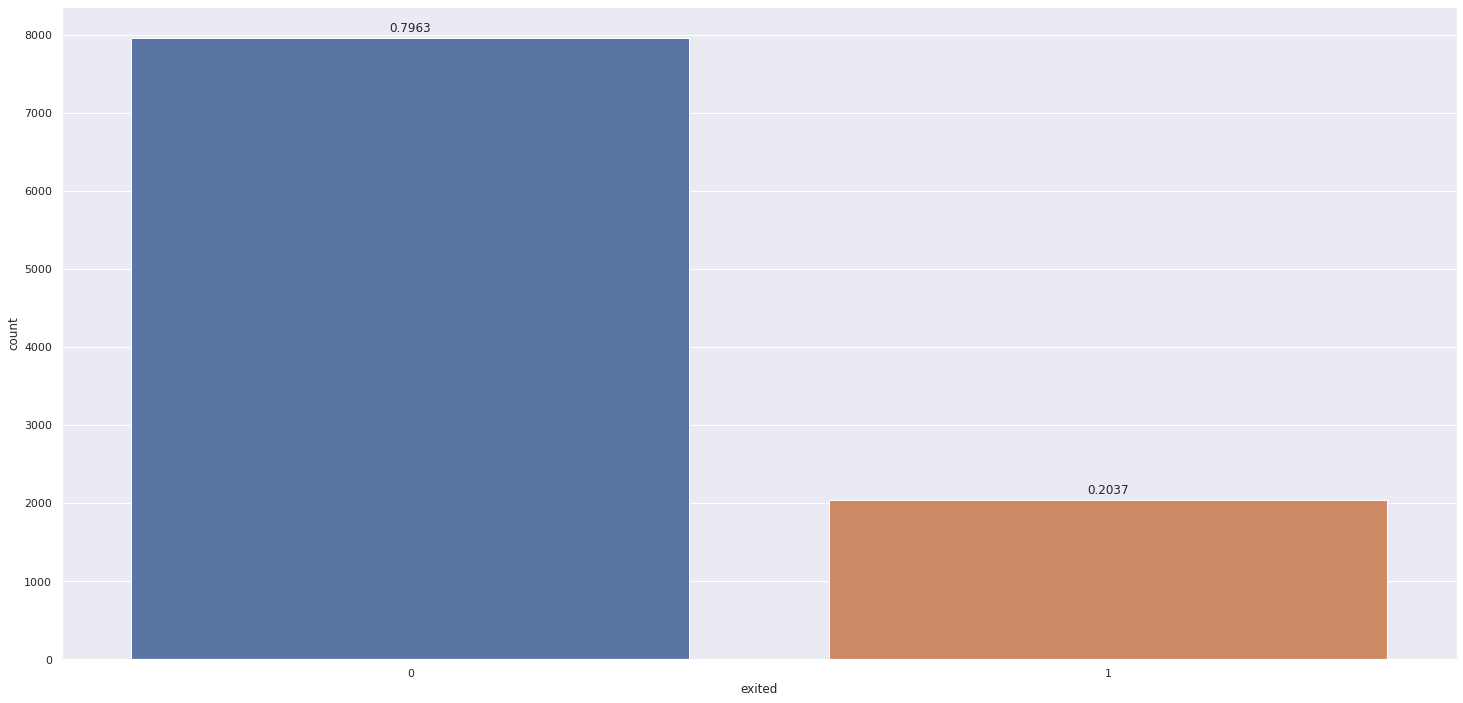

In [17]:
# variable target
plot_cat(cat_attributes['exited'])

obs: very umbalaced variable response

# 2.0. FEATURE ENGINEERING

In [18]:
# copy d1 to df2
df2 = df1.copy()

## 2.1. Hypothesis MindMap

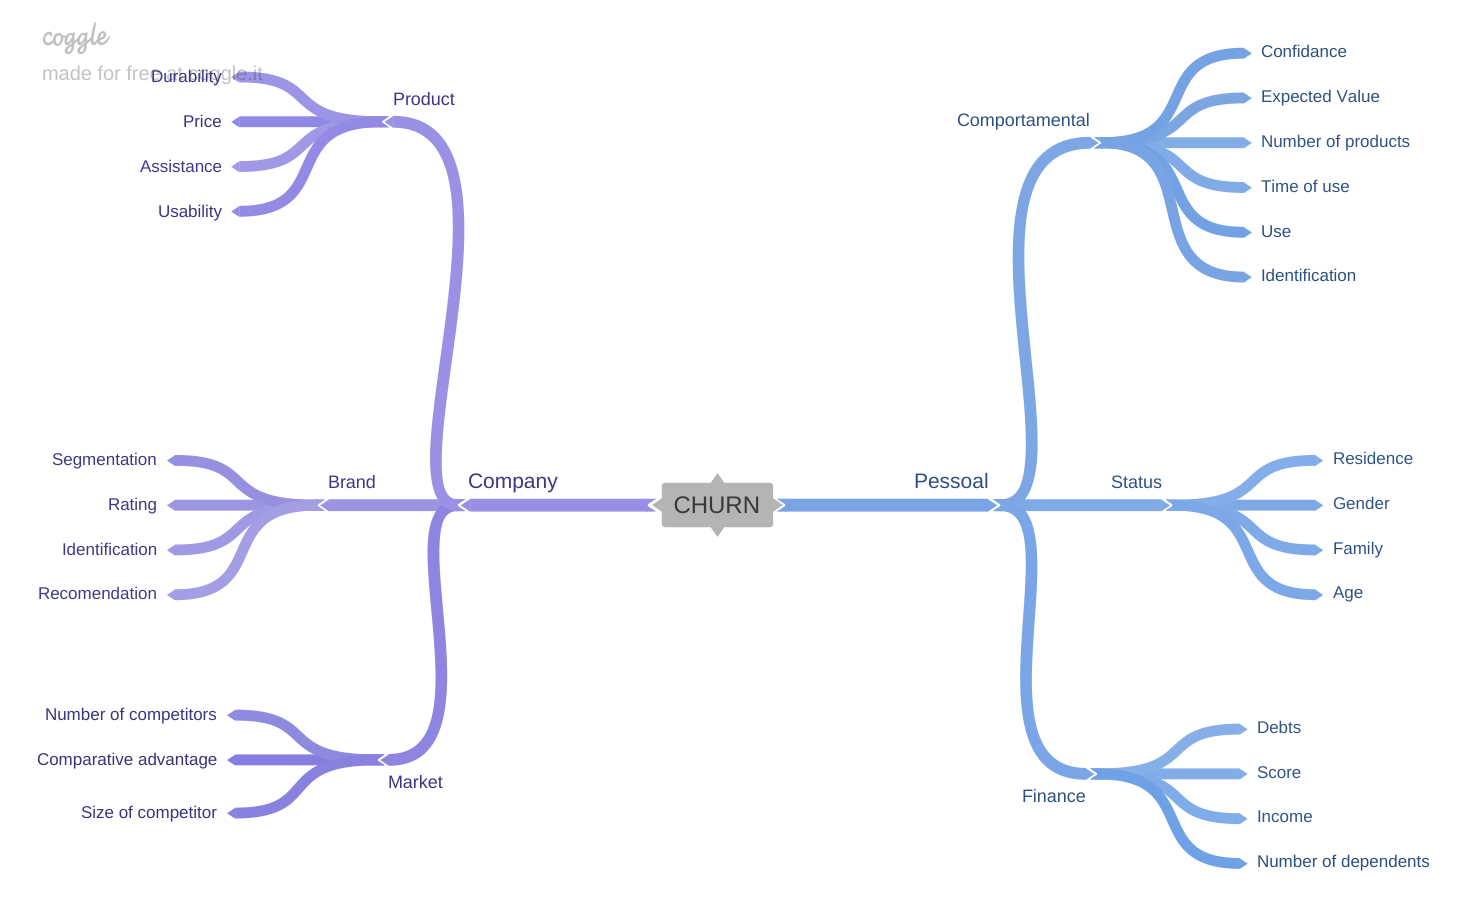

In [19]:
# images
img_url = 'https://raw.githubusercontent.com/tadeucbm/churn_predict/main/image/CHURN.png'
Image(img_url)

## 2.2. Creation of Hypotheses

### 2.2.1. Behavioral Hypothesis
**1**. Old customers have a lower dropout rate than new customers.;

**2**. Customers with more products evade less;

**3**. Customer with credit card tend to evaded less;

**4**. Longer credit card customers tend to evaded less;

**5**. Active customers tend to evaded less.


### 2.2.2. Status Hypothesis
**1**. The customer residence country impacts the dropout rate;

**2**. The gender of the customer has no relation with dropout rate;

**3**. Older people tend to evaded less.


### 2.2.3. Finance Hypothesis
**1**. Indebted people tend to evaded less;

**2**. Customers with a high salary tend to evaded less;

**3**. Customers with a high amount of money in account tend to evaded less (exclude 0);

**4**. Customer with any value in account tend to evaded less;

**5**. Customers with a high score and low amount of money on account tend to evaded more;

**6**. People with a high salary and a low amount of money on account tend to evaded more.


### 2.2.4. Personal Hypothesis
**1**. Non-active customers who do not have a credit card tend to evade more than non-active customers with a credit card;

**2**. Younger credit card customers tend to evade less;

**3**. People who have spent a higher percentage of life as a customer tend to evade less.

## 2.3. Hypothesis Final List

**1**. Old customers have a lower dropout rate than new customers.;

**2**. Customers with more products evade less;

**3**. Customer with credit card tend to evaded less;

**4**. Longer credit card customers tend to evaded less;

**5**. Active customers tend to evaded less;

**6**. The customer residence country impacts the dropout rate;

**7**. The gender of the customer has no relation with dropout rate;

**8**. Older people tend to evaded less;

**9**. Indebted people tend to evaded less;

**10**. Customers with a high salary tend to evaded less;

**11**. Customers with a high amount of money in account tend to evaded less (exclude 0);

**12**. Customer with any value in account tend to evaded less;

**13**. Customers with a high score and low amount of money on account tend to evaded more;

**14**. People with a high salary and a low amount of money on account tend to evaded more;

**15**. Non-active customers who do not have a credit card tend to evade more than non-active customers with a credit card;

**16**. Younger credit card customers tend to evade less;

**17**. People who have spent a higher percentage of life as a customer tend to evade less.

## 2.4. Feature Engineering

In [20]:
# percentage of life the person is a customer
df2['perc_tenure'] = df2['tenure'] / df2['age']
df2['perc_tenure'] = df2['perc_tenure'].astype('float64')

# comparison between score and money account
df2['score_account'] = df2['balance'] / df2['credit_score']

# creating classes for the score 
df2['score_class'] = df2['credit_score'].apply(lambda x: 'high_risk' if x < 500 else
                                                         'med_risk' if x >= 500 and x < 700 else
                                                         'low_risk' if x >= 700 and x < 800 else
                                                         'very_low_risk')

# creating classes to age
df2['age_category'] = df2['age'].apply(lambda x: '18 - 29' if x >= 18 and x <= 30 else
                                                 '30 - 39' if x >= 30 and x < 40 else
                                                 '40 - 49' if x >= 40 and x < 50 else
                                                 '50 - 59' if x >= 50 and x < 60 else
                                                 '60 +')

# create binary variable - balance
df2['have_balance'] = df2['balance'].apply(lambda x: 1 if x > 0 else 0)

# create categories to salary
df2['cat_salary'] = pd.cut(df2['estimated_salary'], 10)

In [21]:
# drop surname
df2.drop('surname', inplace=True, axis=1)

# 3.0. Exploratory Data Analysis

In [22]:
# copy df2 to df3
df3 = df2.copy()

## 3.1. Univariate Analysis

### 3.1.1. Response Variable 
- The response variable is unbalanced;

- 79.6% not churn and 20.4% churn

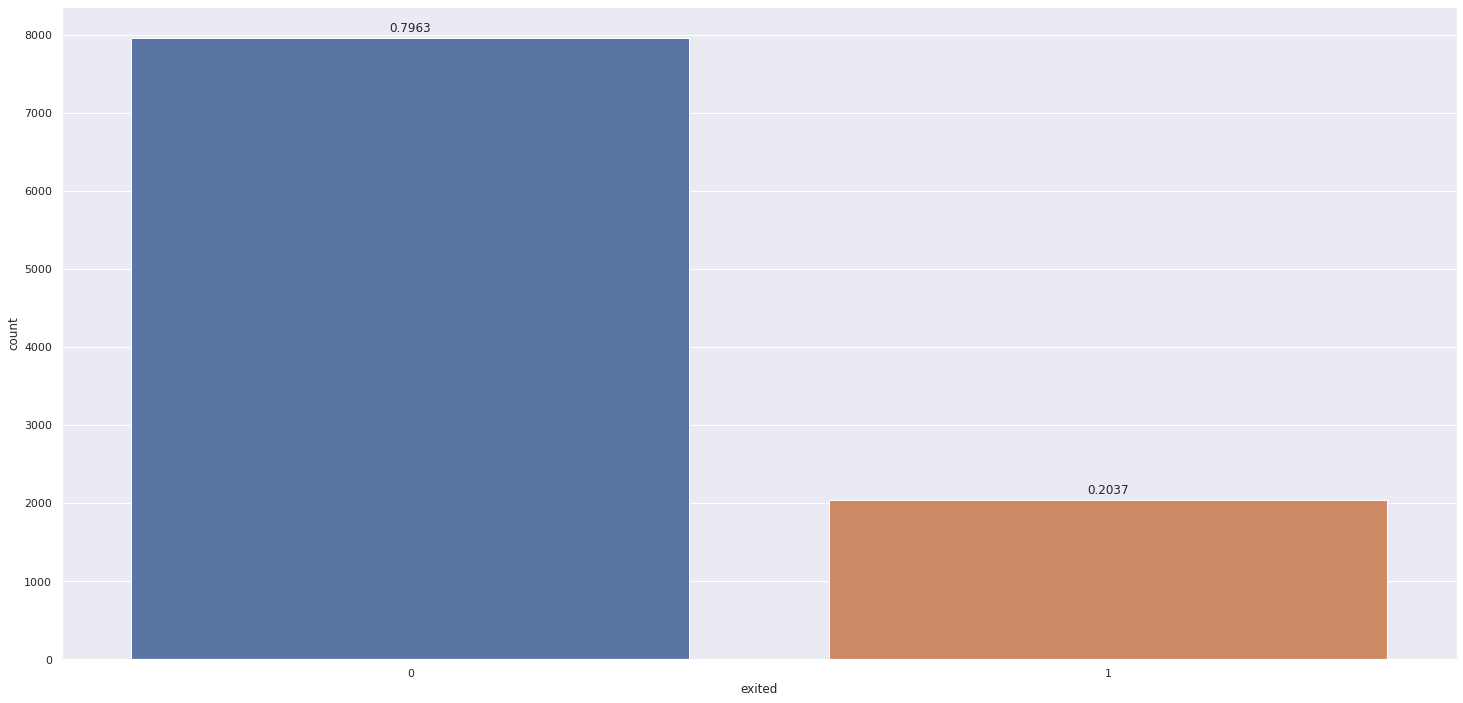

In [23]:
# plot response variable
plot_cat(df3['exited'])

### 3.1.2. Numerical Variables

#### 3.1.2.1 Credit Score
- Credit_score is a variable that approaches a normal distribution,

- There are many entries with the maximum value

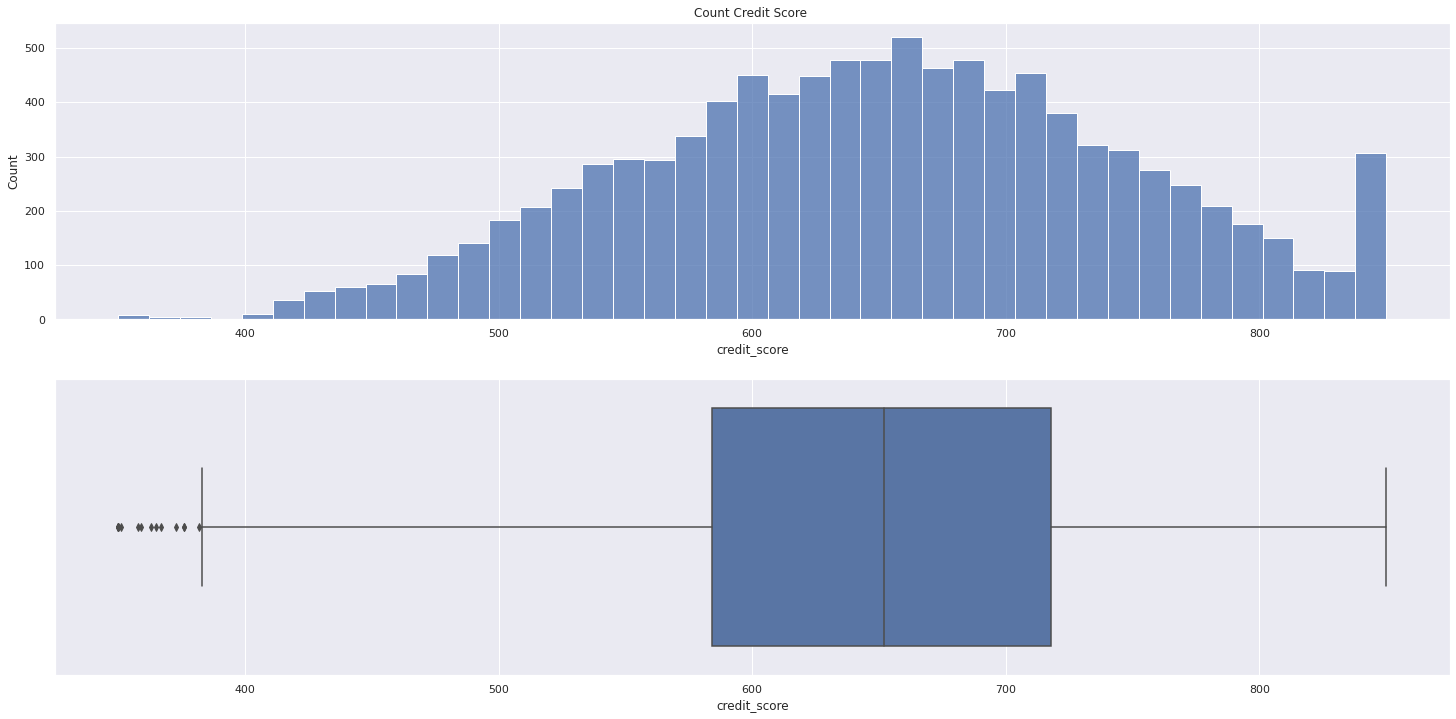

In [24]:
# plot histogram and boxplot of credit_score
plot_dist(df3['credit_score'], title='Count Credit Score ')

#### 3.1.2.2 Age
- The skew of the variable age is positive

- Elderly people are outliers

- Some values of age stand out with high values

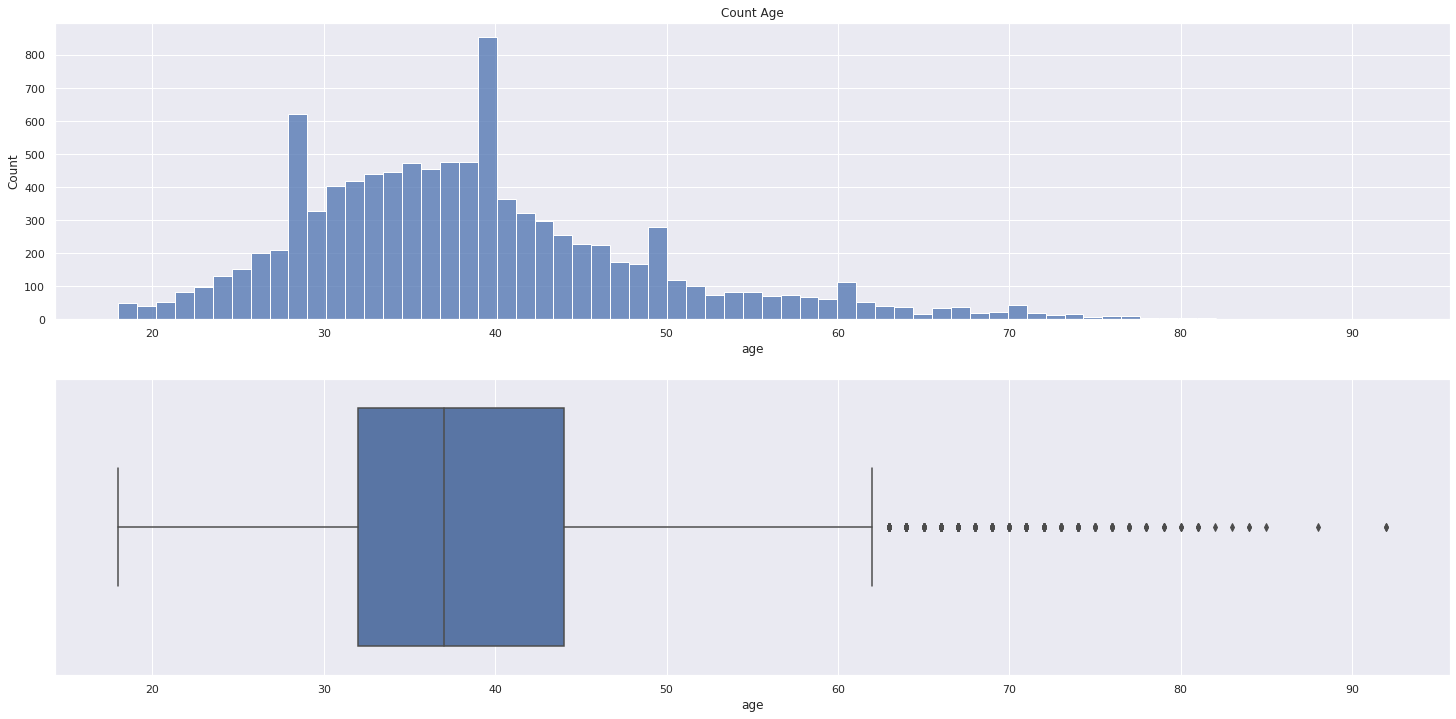

In [25]:
# plot histogram and boxplot of age
plot_dist(df3['age'], title='Count Age')

#### 3.1.2.3 Balance
- 36% of values are 0 and 64% of values are > 0

- The distribution of the balance variable approach to normal, when without 0 values

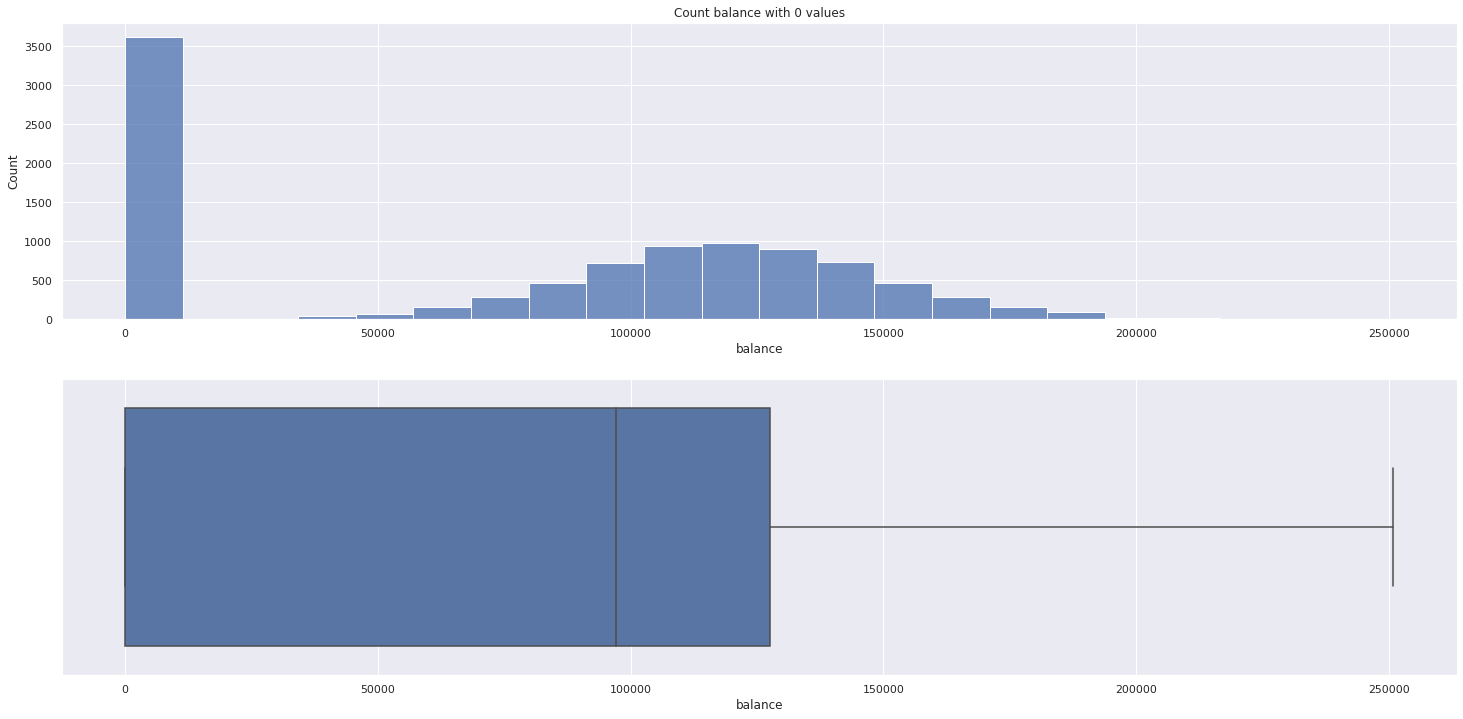

In [26]:
# plot balance with 0 balance values
plot_dist(df3['balance'], title='Count balance with 0 values')

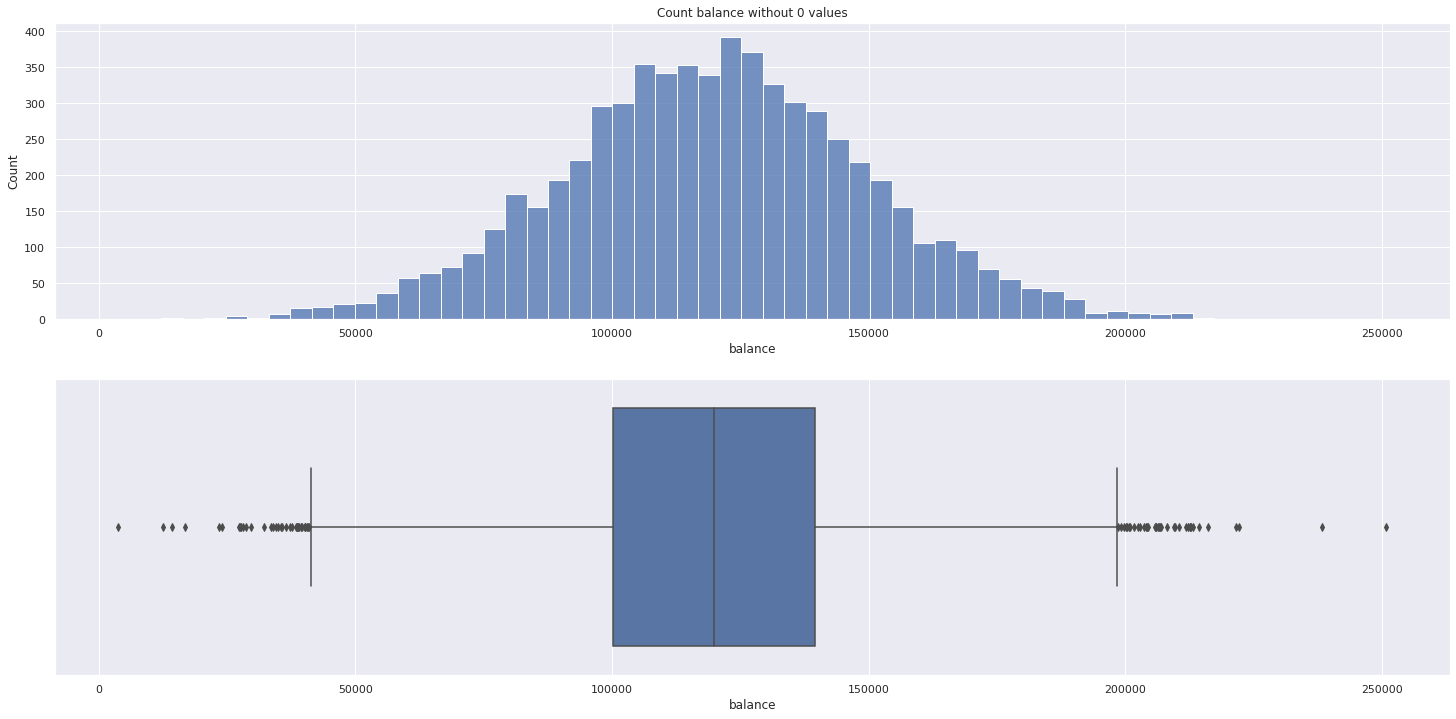

In [27]:
# histogram and boxplot of balance without 0 values
aux_2 = df3.loc[df3['balance'] > 0, 'balance']
plot_dist(aux_2, title='Count balance without 0 values')

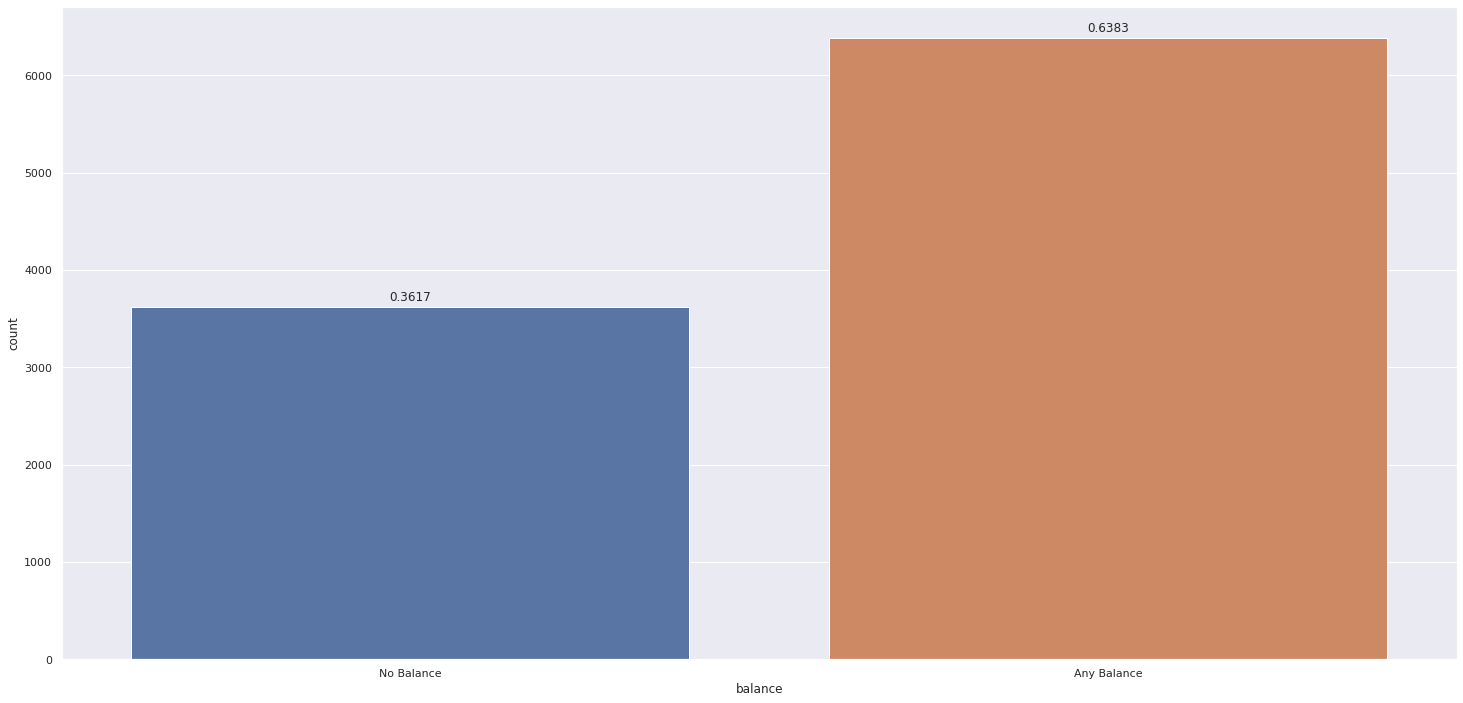

In [28]:
# count number of balance = 0 and balance > 0
aux_1 = df3['balance'].apply(lambda x: 'No Balance' if x == 0 else 'Any Balance')
plot_cat(aux_1)

#### 3.1.2.4 Estimated Salary
- The variable estimated salary is very balanced

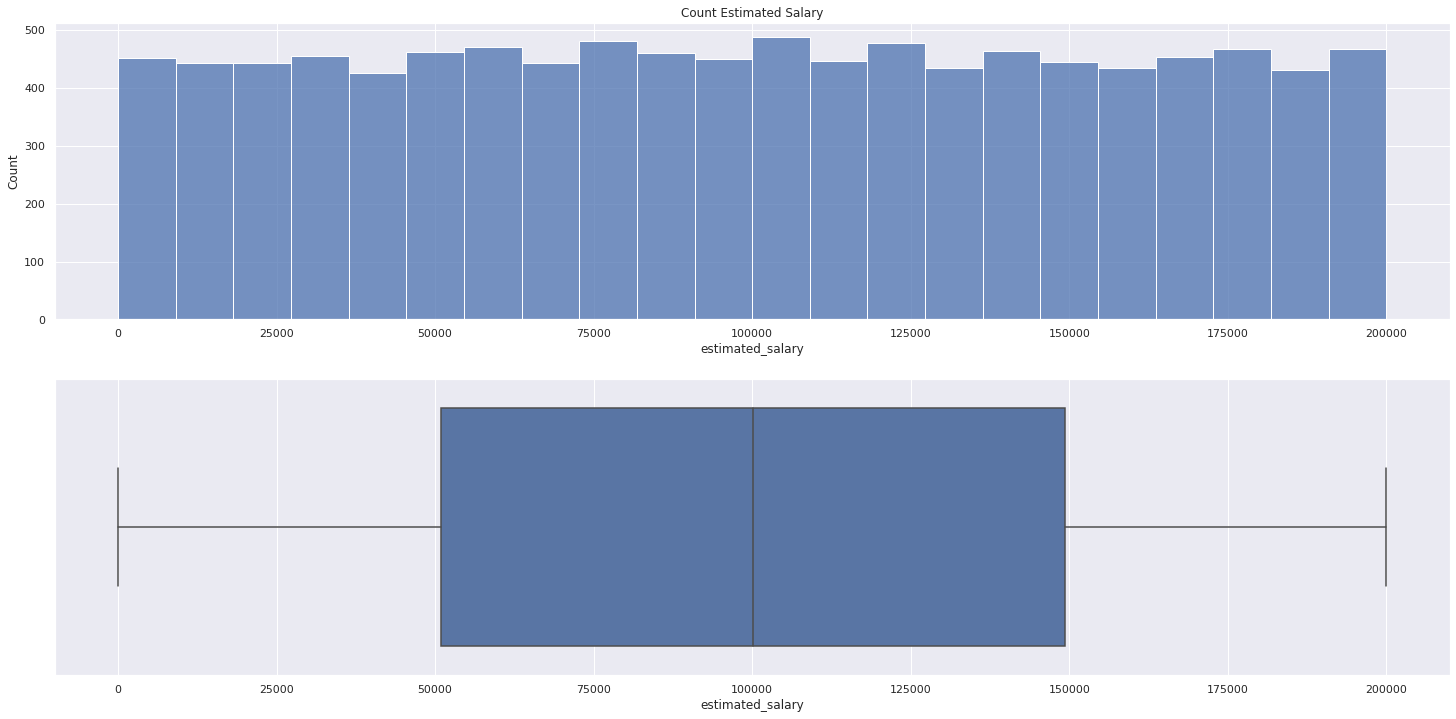

In [29]:
# plot balance with 0 balance values
plot_dist(df3['estimated_salary'], title='Count Estimated Salary')

#### 3.1.2.5 perc_tenure
- The skew of the variable perc_tenure is positive

- Values greater than 0.4 are outliers

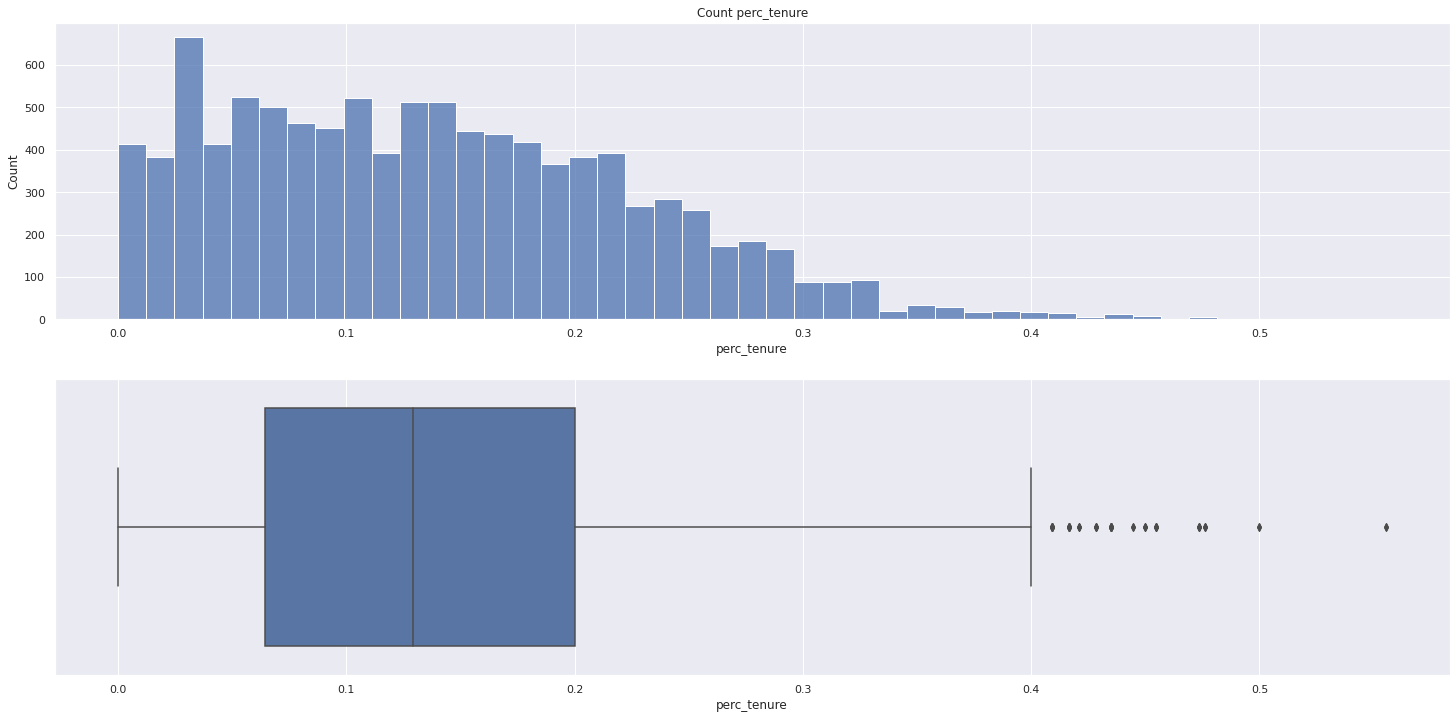

In [30]:
# plot perc_tenure
plot_dist(df3['perc_tenure'], title='Count perc_tenure')

#### 3.1.2.6 score_account
The distribution of the balance variable approach to normal, when without 0 values. But, your skew is positive.

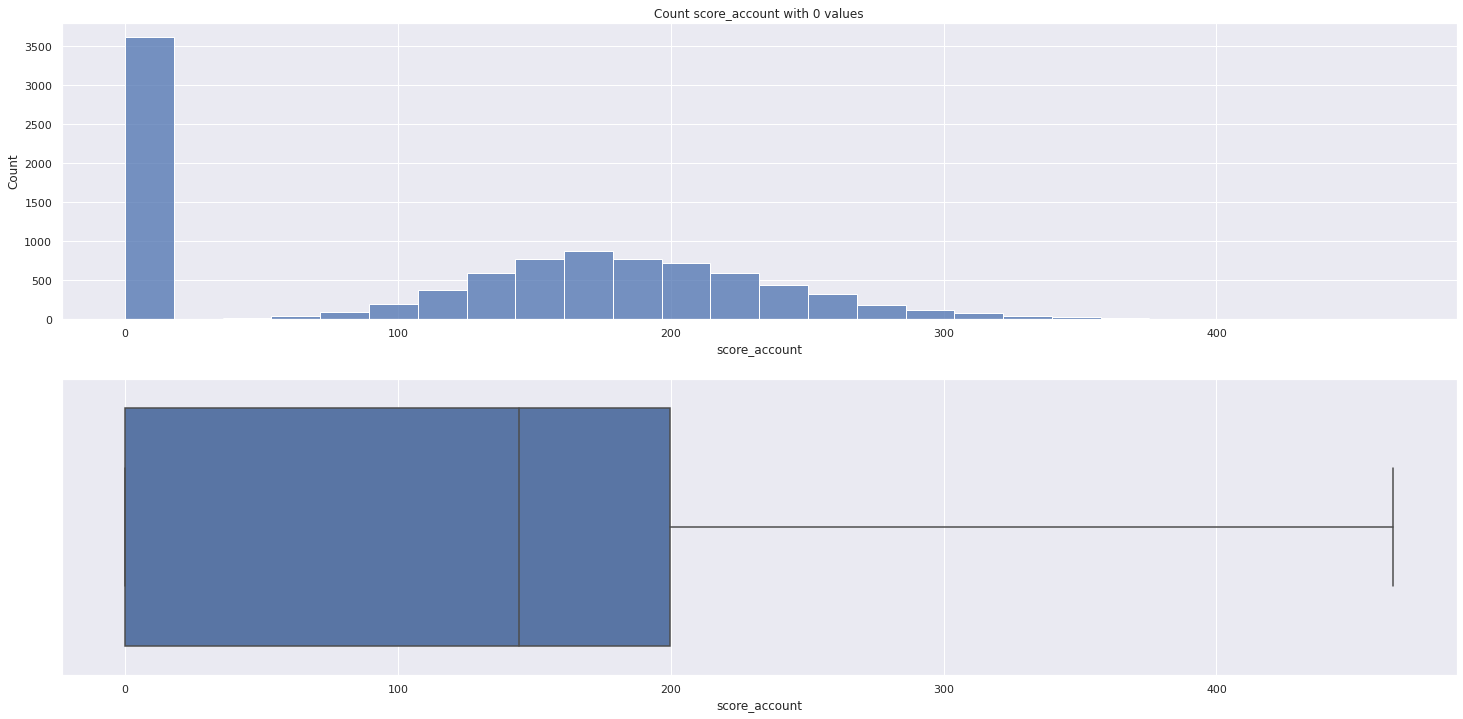

In [31]:
# plot score_account
plot_dist(df3['score_account'], title='Count score_account with 0 values')

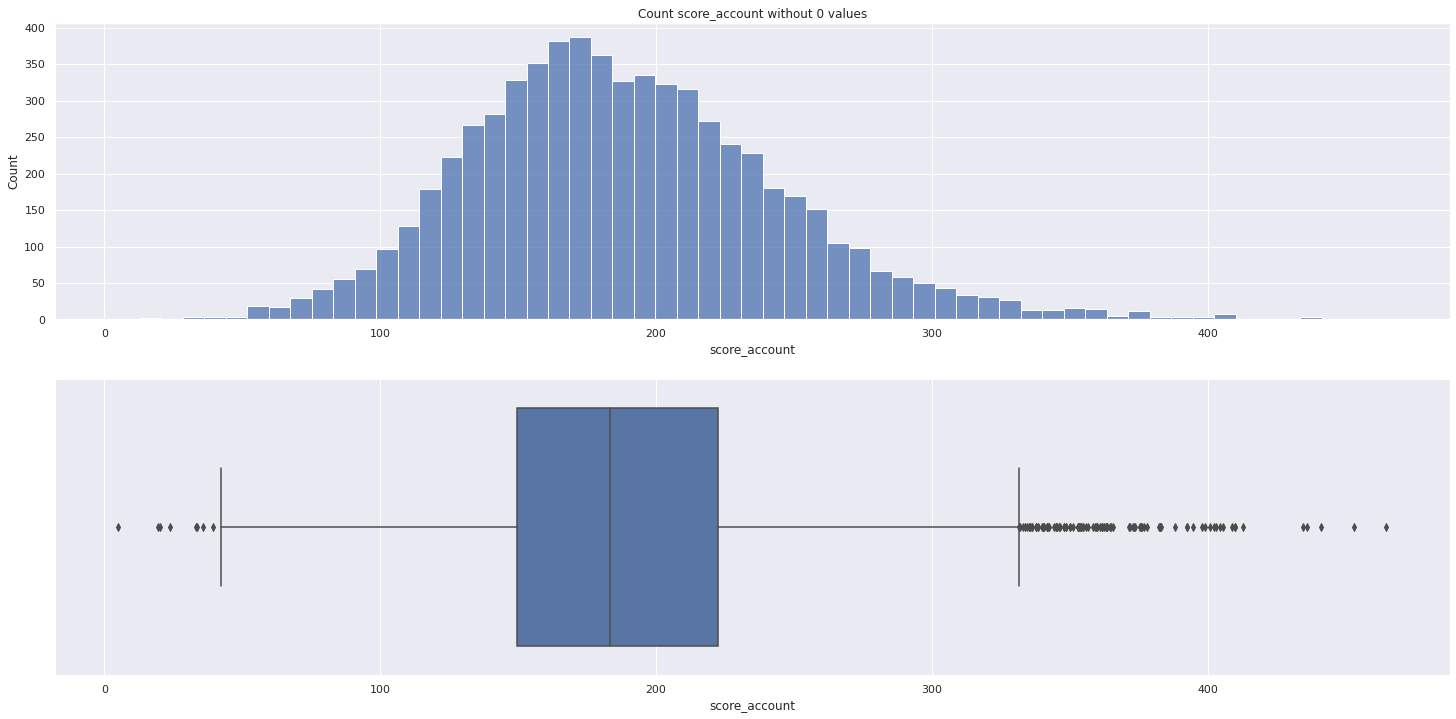

In [32]:
aux_2 = df3.loc[df3['score_account'] > 0, 'score_account']
plot_dist(aux_2, title='Count score_account without 0 values')

### 3.1.3. Categorical Variables

- More than half of the data are from French;

- More men than women;

- The time as a customer is well balanced, with the exception of the tips that are low;

- 95% of customers own up to 2 products;

- 70% of customers have a credit card;

- Approximately half of the customers are active, the other half are not.

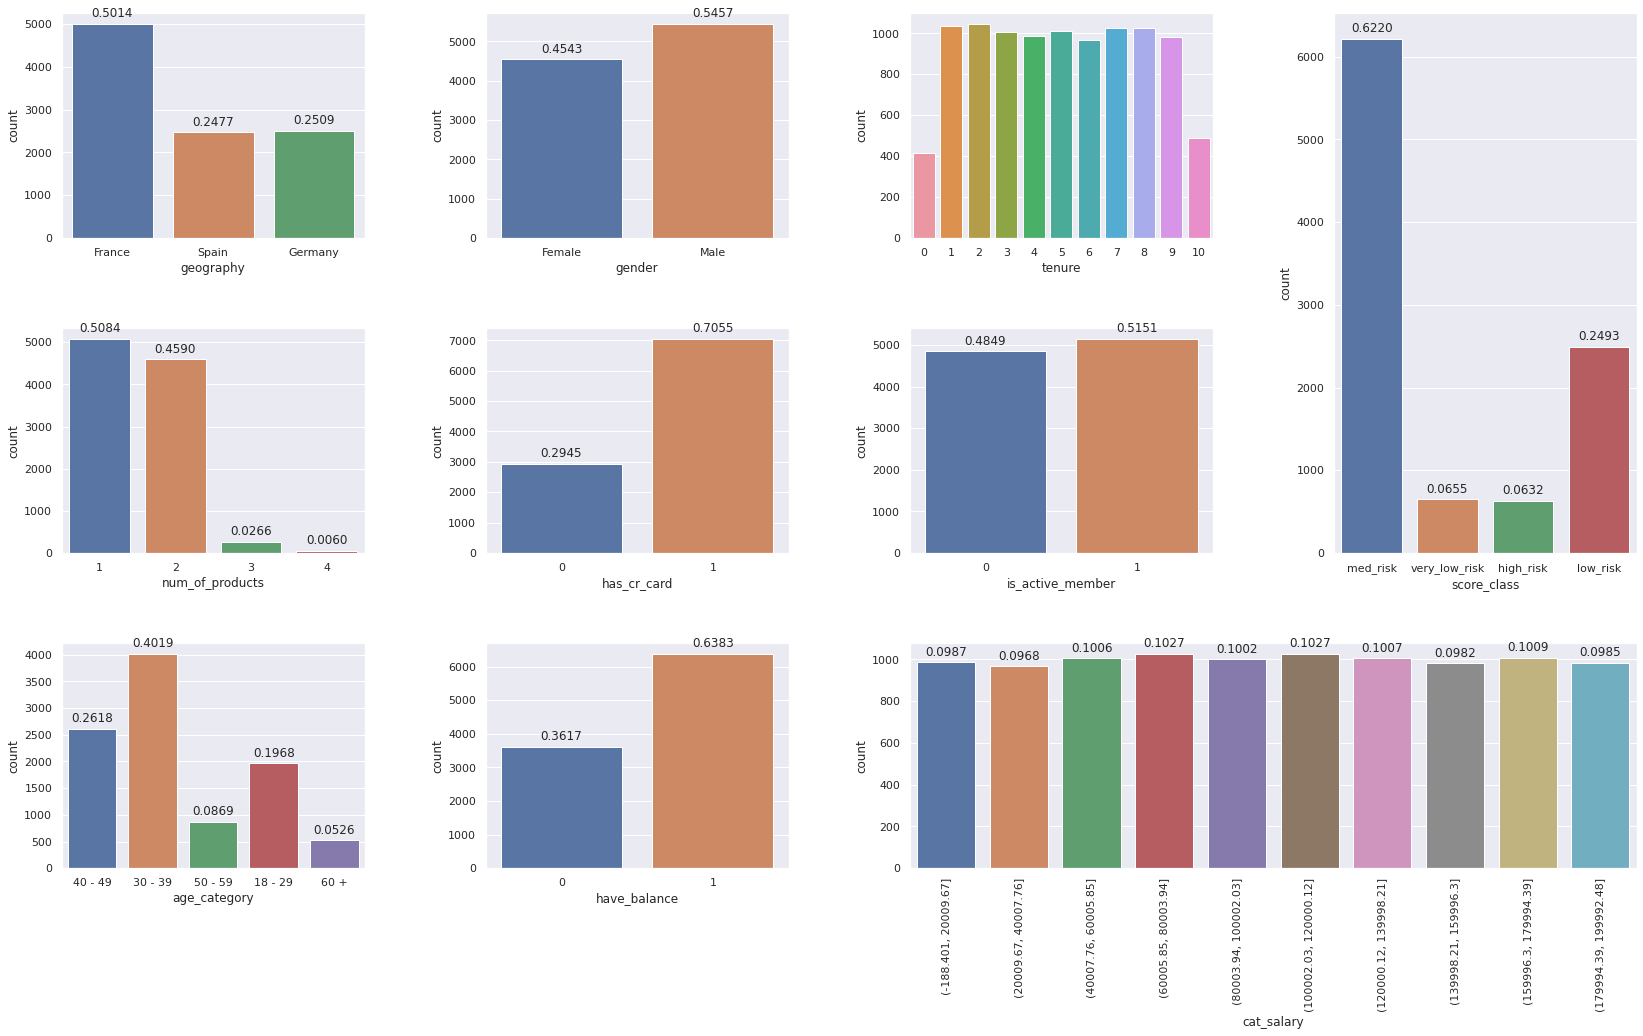

In [33]:
# create grid
grid = plt.GridSpec(3, 4)

# print countplot geography
plt.subplot(grid[0, 0])
plot_cat(df3['geography'])

# print countplot gender
plt.subplot(grid[0, 1])
plot_cat(df3['gender'])

# print countplot tenure
plt.subplot(grid[0, 2])
plot_cat(df3['tenure'], annot=False)

# print countplot num_of_products
plt.subplot(grid[1, 0])
plot_cat(df3['num_of_products'])

# print countplot has_cr_card
plt.subplot(grid[1, 1])
plot_cat(df3['has_cr_card'])

# print countplot is_active_member
plt.subplot(grid[1, 2])
plot_cat(df3['is_active_member'])

# print countplot is_active_member
plt.subplot(grid[2, 0])
plot_cat(df3['age_category'])

# print countplot is_active_member
plt.subplot(grid[2, 1])
plot_cat(df3['have_balance'])

# print countplot is_active_member
plt.subplot(grid[2, 2:4])
plot_cat(df3['cat_salary'])
plt.xticks(rotation=90)

# print countplot is_active_member
plt.subplot(grid[0:2, 3])
plot_cat(df3['score_class'])

plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=1, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.40)

## 3.2. Bivariate Analysis

### H1. Old customers have a lower dropout rate than new customers. - FALSE
Old customers have a slightly lower dropout rate than younger customers. However, the correlation between the variables is low.

In [34]:
# Create a crosstab with variables tenure and exited
aux = pd.crosstab(df3['tenure'], df3['exited']).reset_index()
aux['percent'] = aux[1] / (aux[0] + aux[1])

# create aux_2 dataframe
aux_2 = pd.DataFrame({k:1 for k in range(0, 11)}, index=[0]).T.reset_index()

<AxesSubplot:xlabel='index', ylabel='percent'>

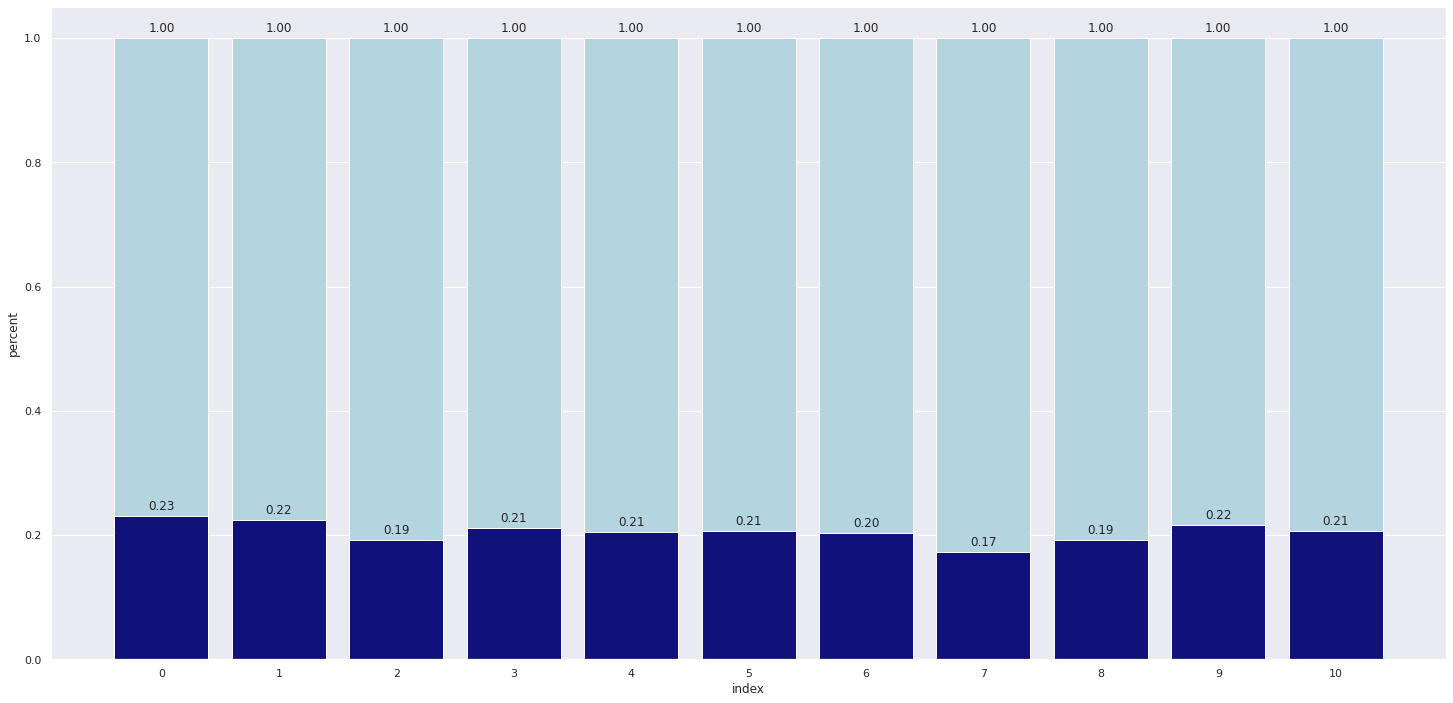

In [35]:
# plot percentage bar of each number of products
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=aux['percent'], color='darkblue')


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')
        
sns.lineplot(x = aux['percent'])

### H2. Customers with more products evade less - FALSE
The number of products has a peculiar behavior:
- 27.71% of customers with 1 products evaded;
- 7.58% of customers with 2 products evaded;
- **82.71%** of customers with 3 products evaded;
- **100%** of customers with 4 products evaded.

Therefore, customers with more products tend to evade more.

In [36]:
# Create a crosstab with variables numer_of_products and exited
aux = pd.crosstab(df3['num_of_products'], df3['exited'])
aux['percentage'] = round(aux[1] / (aux[0] + aux[1]), 4) * 100

In [37]:
aux

exited,0,1,percentage
num_of_products,,,
1,3675,1409,27.71
2,4242,348,7.58
3,46,220,82.71
4,0,60,100.00


Text(0.5, 1.0, 'Evasion or not for all number of products')

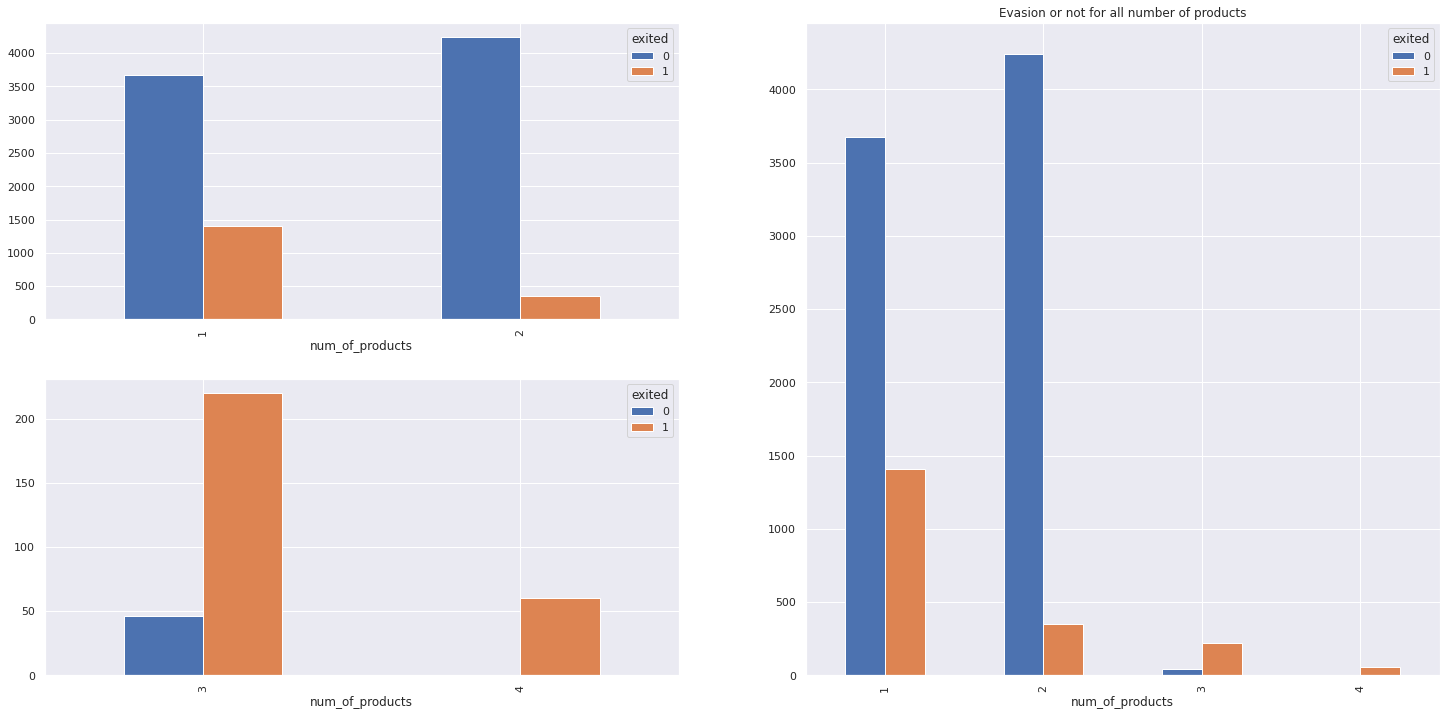

In [38]:
# create fig and grids
grid = plt.GridSpec(2, 2)
fig=plt.figure()
ax1=fig.add_subplot(grid[0, 0])
ax2=fig.add_subplot(grid[1, 0])
ax3=fig.add_subplot(grid[:, 1])

# 1 or 2 products
aux.iloc[:2, :-1].plot.bar(ax = ax1)

# 3 or 4 products
aux.iloc[2:, :-1].plot.bar(ax = ax2)

# all products
aux.iloc[:, :-1].plot.bar(ax = ax3)
plt.title('Evasion or not for all number of products')

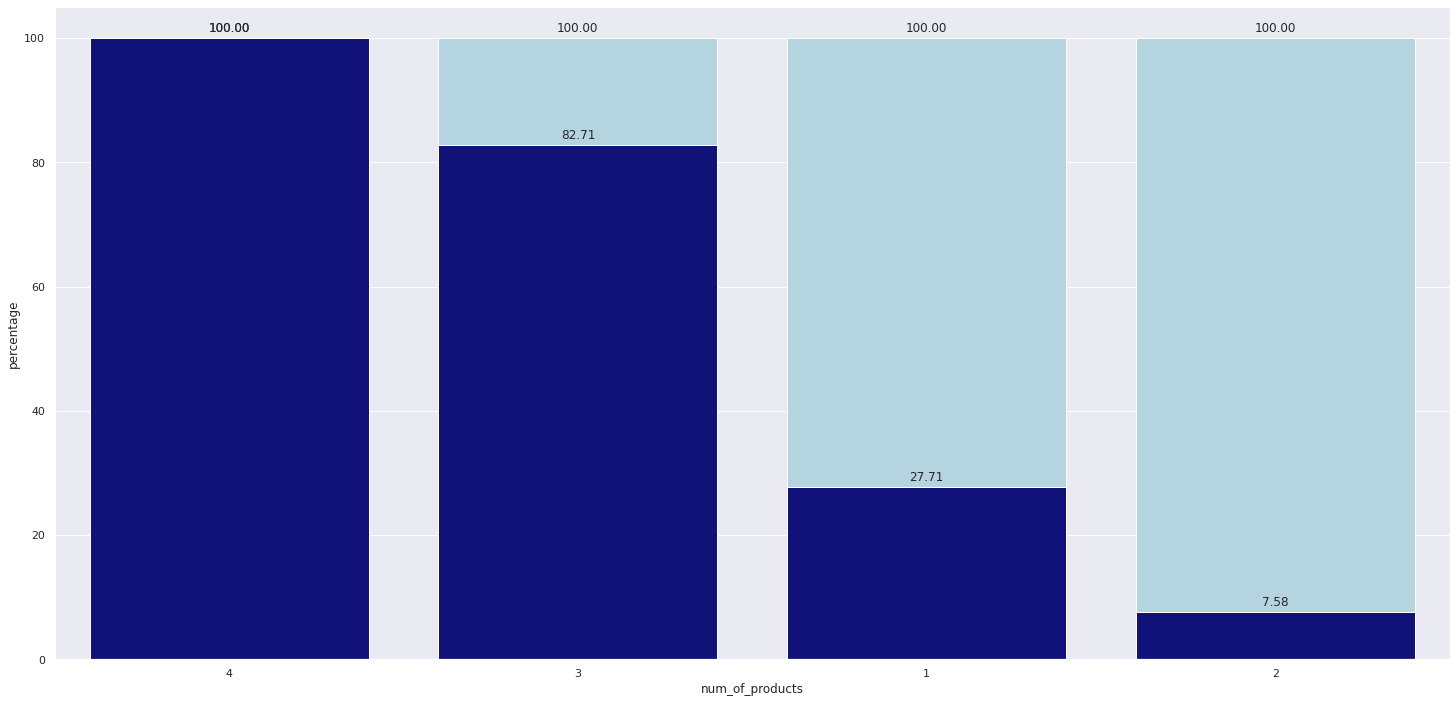

In [39]:
# auxiliar dataframe
aux_2 = pd.DataFrame({k:100 for k in range(1, 5)}, index=[0]).T.reset_index()

# plot percentage bar of each number of products
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], order=[4, 3, 1, 2], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=aux['percentage'], order=[4, 3, 1, 2], color='darkblue')


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

### H3. Customer with credit card tend to evaded less - FALSE
- No correlation between variables 'has_credit_card' and 'exited'

In [40]:
# Create a crosstab with variables has_cr_card and exited
aux = pd.crosstab(df3['has_cr_card'], df3['exited'])
aux['total'] = round(aux[1] / (aux[0] + aux[1]) * 100, 2)

# auxiliar dataframe
aux_2 = pd.DataFrame({0: 100, 1: 100}, index=[0]).T.reset_index()

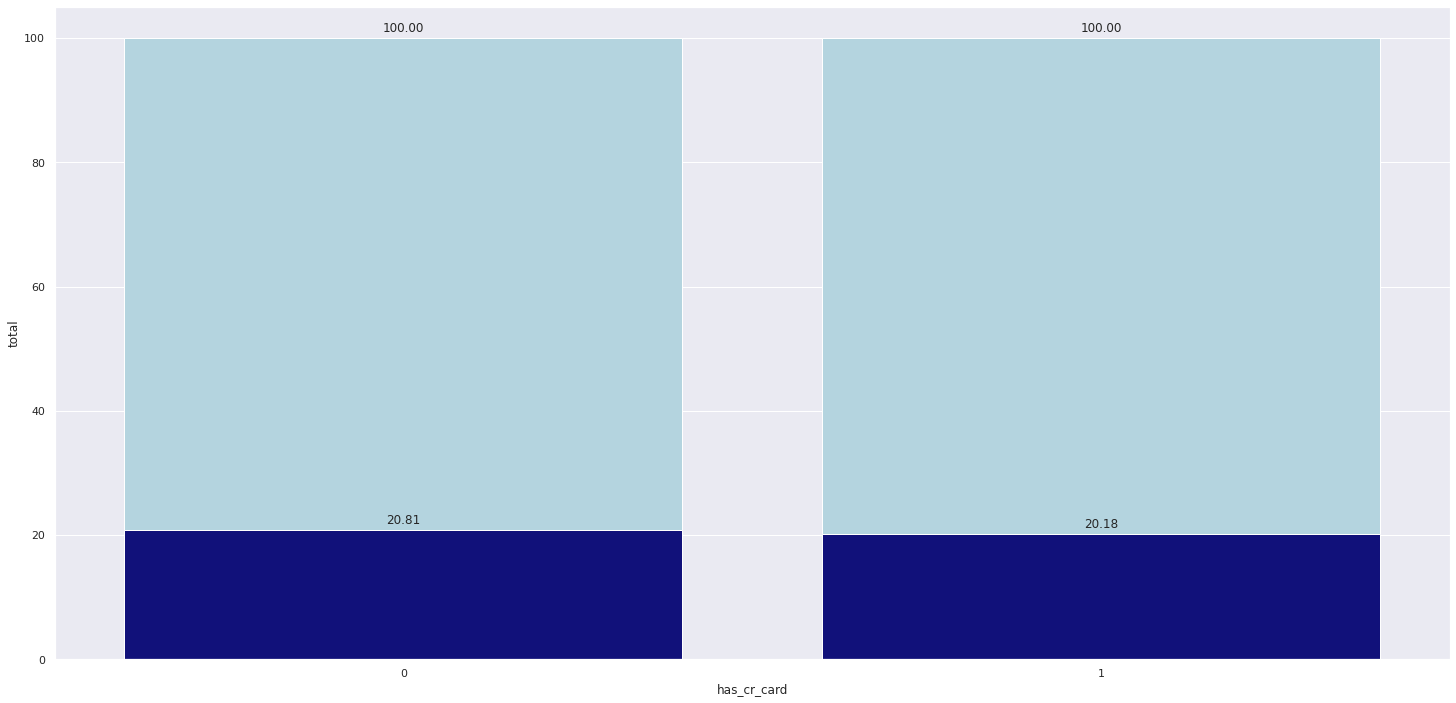

In [41]:
# plot percentage bar of each number of products
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=aux['total'], color='darkblue')


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

### H4. Longer credit card customers tend to evaded less - FALSE
- No correlation betweens this variables

In [42]:
# create aux -> crosstab 
aux = pd.crosstab(df3['exited'], [df3['has_cr_card'], df3['tenure']]).T
aux['percentage'] = aux[1] / (aux[0] + aux[1])

In [43]:
# create aux_2
aux_2 = aux.reset_index()
aux_2 = aux_2.loc[aux_2['has_cr_card'] == 1, :].reset_index(drop=True)
aux_2.index.name = 'index'
aux_2.sort_values(by='percentage', inplace=True)

In [44]:
# create aux_3 dataframe
aux_3 = pd.DataFrame({k:1 for k in range(0, 11)}, index=[0]).T.reset_index()

In [45]:
# Create aux_4 
aux_4 = pd.crosstab(df3['tenure'], df3['exited']).reset_index()
aux_4['percentage'] = aux_4[1] / (aux_4[0] + aux_4[1])

In [46]:
# Create aux_5 
aux_5 = pd.DataFrame([aux_2['percentage'], aux_4['percentage']]).T
aux_5.columns = ['percentage_all', 'percentage_old_credit']
aux_5['var'] = 1 - (aux_5['percentage_all'] / aux_5['percentage_old_credit'])

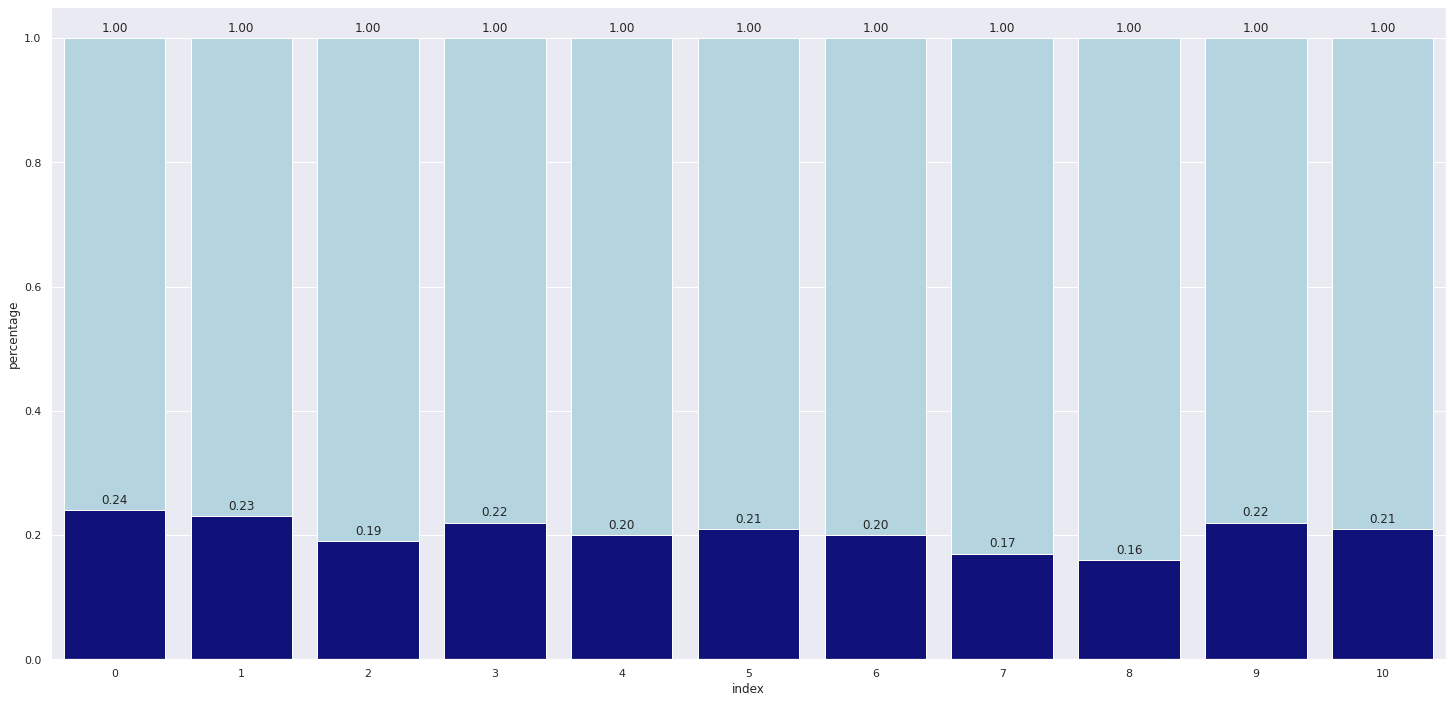

In [47]:
# plot percentage bar of each number of products
bar1 = sns.barplot(x=aux_3['index'], y=aux_3[0], color='lightblue')
bar2 = sns.barplot(x=aux_2.index, y=round(aux_2['percentage'], 2), color='darkblue')


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

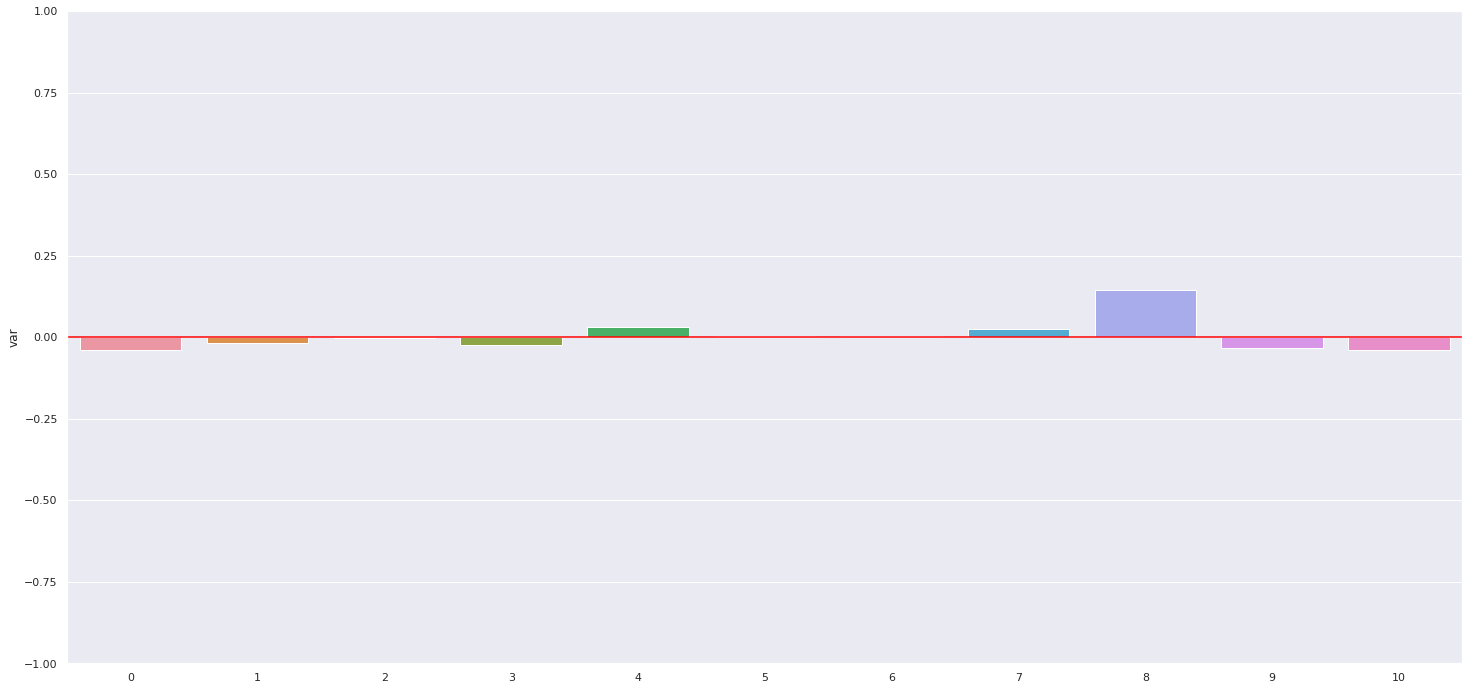

In [48]:
# plot variation between de percentage of tenure normal and tenure with credit_card
sns.barplot(x = aux_5.index, y = aux_5['var'], )

eixos = plt.gca()
eixos.set_ylim([-1, 1])

plt.axhline(y=0, color='red')

### H5. Active customers tend to evaded less. - TRUE
Non-active customers tend to evade more than active customers.

In [49]:
# create aux dataframe
aux = pd.crosstab(df3['is_active_member'], df3['exited']).reset_index(drop=True)
aux['percentage'] = aux[1] / (aux[0] + aux[1]) * 100

In [50]:
# create aux_2 dataframe
aux_2 = pd.DataFrame({k:100 for k in range(0, 2)}, index=[0]).T.reset_index()

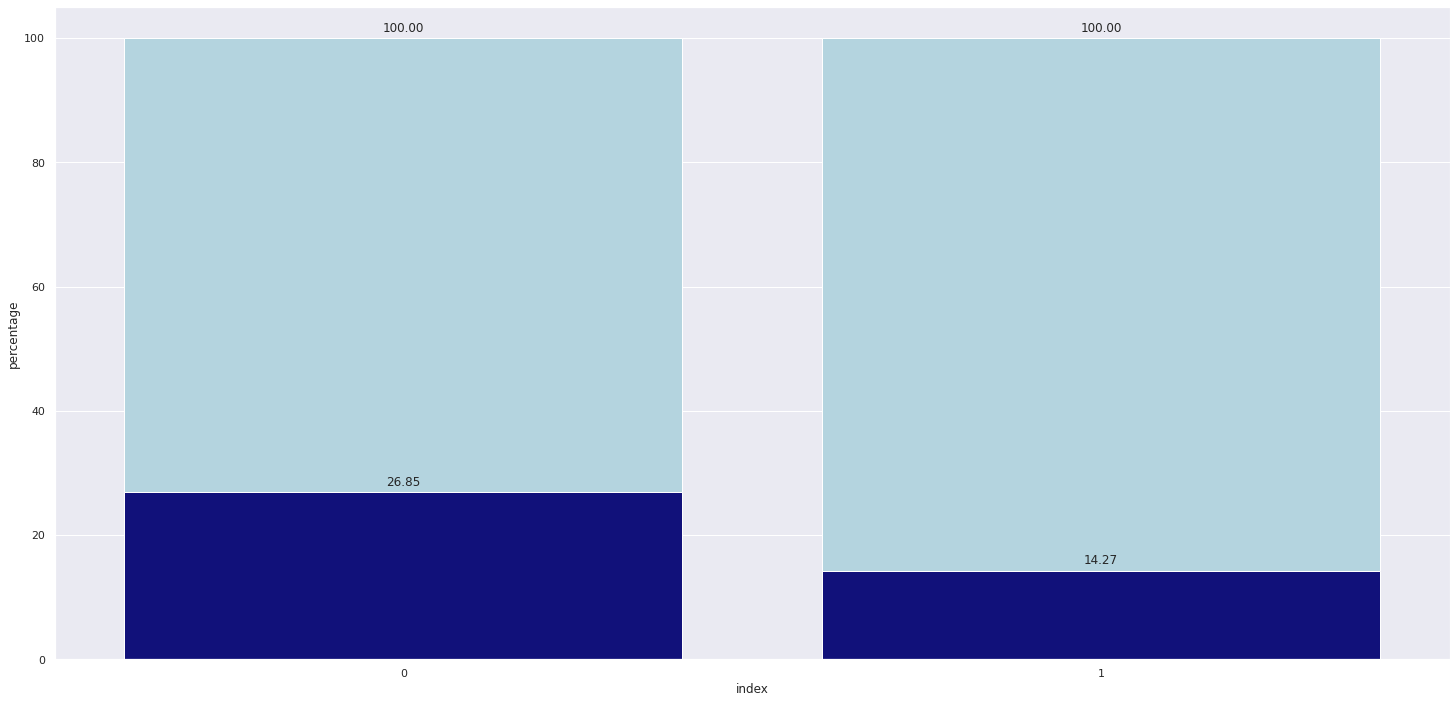

In [51]:
# plot percentage bar of each value for 'is_active_member'
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=round(aux['percentage'], 2), color='darkblue')


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

### H6. The customer residence country impacts the dropout rate - TRUE
the dropout rate for German customers is higher than for other customer nationalities.

In [52]:
# create aux -> crosstab 
aux = pd.crosstab(df3['geography'], df3['exited'])
aux['percentage'] = aux[1] / (aux[0] + aux[1]) * 100
aux.sort_values(by='percentage', inplace=True, ascending=False)

In [53]:
# create aux_2 dataframe
aux_2 = pd.DataFrame({k:100 for k in range(0, 3)}, index=[0]).T.reset_index()

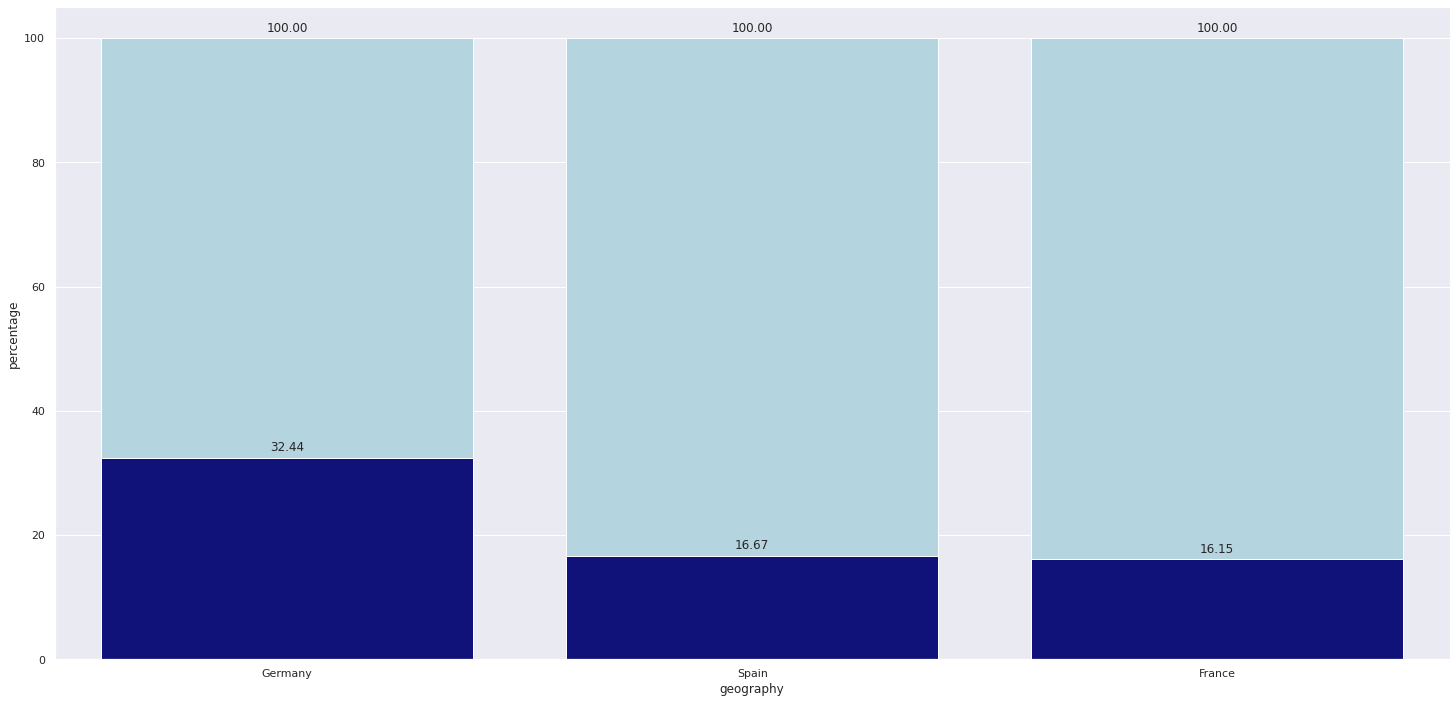

In [54]:
# plot percentage bar of each value for country
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=round(aux['percentage'], 2), color='darkblue', order = aux.index)


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

### H7. The gender of the customer has no relation with dropout rate. - FALSE
the female gender has a higher dropout rate.

In [55]:
# create aux -> crosstab 
aux = pd.crosstab(df3['gender'], df3['exited'])
aux['percentage'] = aux[1] / (aux[0] + aux[1]) * 100
aux.sort_values(by='percentage', inplace=True, ascending=False)

In [56]:
# create aux_2 dataframe
aux_2 = pd.DataFrame({k:100 for k in range(0, 2)}, index=[0]).T.reset_index()

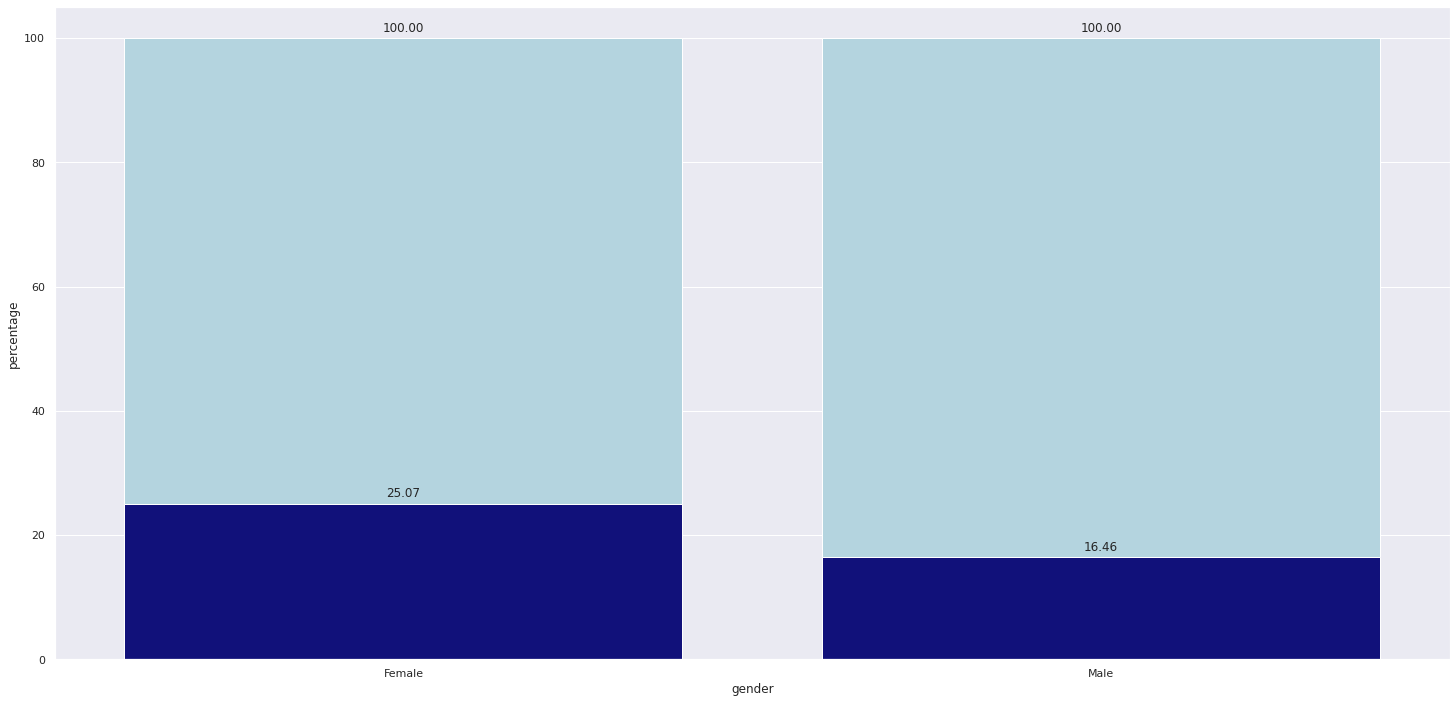

In [57]:
# plot percentage bar of each value for gender
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=round(aux['percentage'], 2), color='darkblue', order = aux.index)


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

### H8. Older people tend to evaded less - FALSE
Older people tend to evaded more. However, after 60 years of age, the dropout rate decreases.

In [58]:
# create aux - crosstab between agr_category and exited - with percentage of 1
aux = pd.crosstab(df3['age_category'], df3['exited'])
aux['percentage'] = aux[1] / (aux[0] + aux[1]) * 100

In [59]:
# create aux_2 dataframe
aux_2 = pd.DataFrame({k:100 for k in range(0, 5)}, index=[0]).T.reset_index()

<AxesSubplot:xlabel='exited', ylabel='age'>

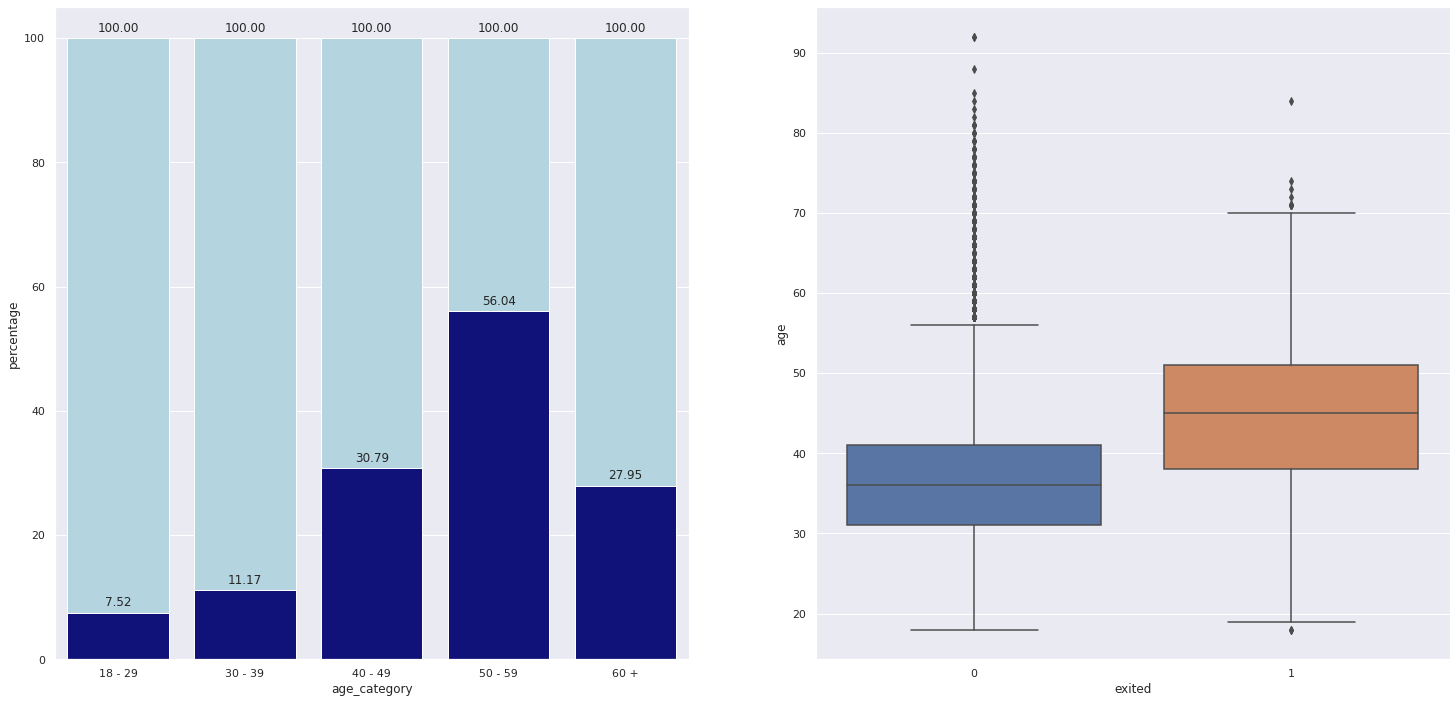

In [60]:
grid = plt.GridSpec(1, 2)

plt.subplot(grid[0, 0])
# plot percentage bar of each value for age_category
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=round(aux['percentage'], 2), color='darkblue', order = aux.index)


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')
        
plt.subplot(grid[0, 1])
sns.boxplot(x=df3['exited'], y=df3['age'])

### H9. Indebted people tend to evaded less - FALSE
There is a tendency to evade customers with lower scores (high risk). However, this trend is not high enough.

In [61]:
# create aux - crosstab between score_class and exited - with percentage of 1
aux = pd.crosstab(df3['score_class'], df3['exited'])
aux['percentage'] = aux[1] / (aux[0] + aux[1]) * 100
aux.sort_values(by='percentage', inplace=True, ascending=False)

In [62]:
# create aux_2 dataframe
aux_2 = pd.DataFrame({k:100 for k in range(0, 4)}, index=[0]).T.reset_index()

<AxesSubplot:xlabel='exited', ylabel='credit_score'>

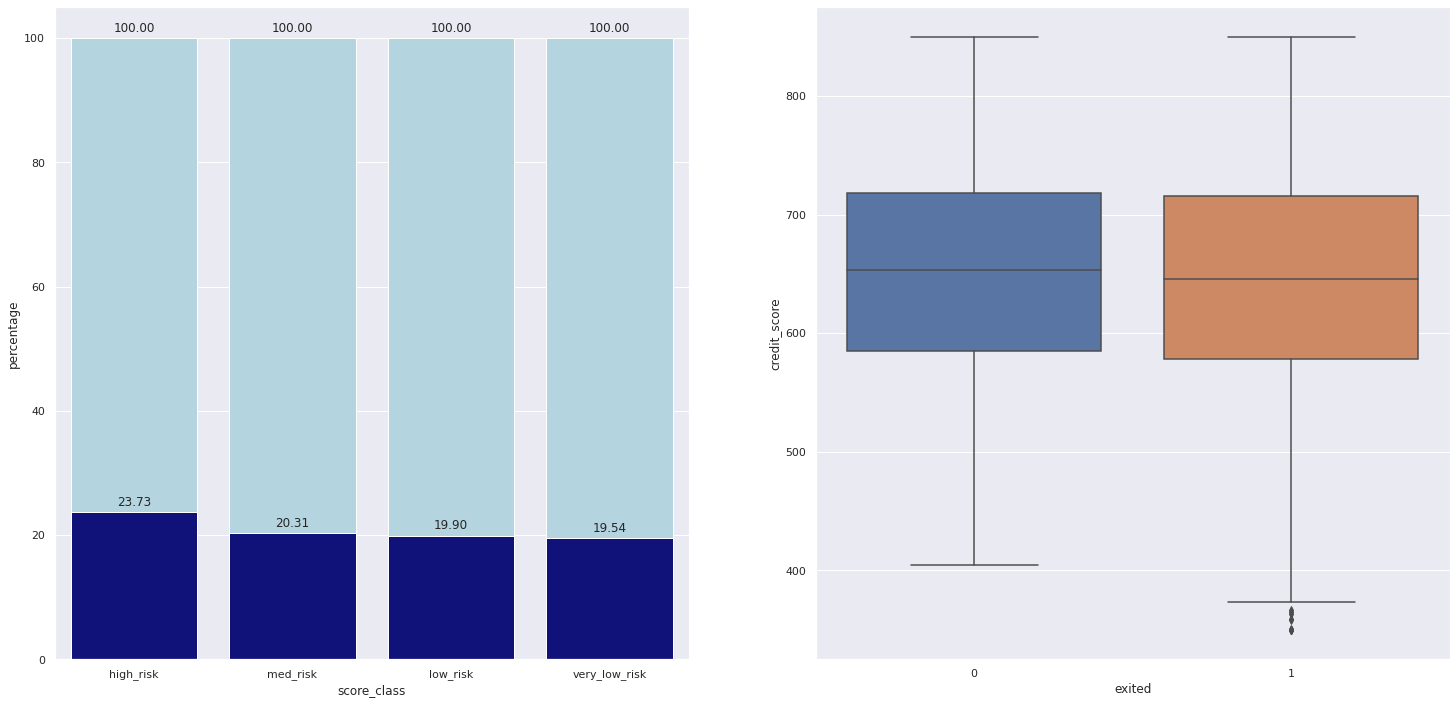

In [63]:
grid = plt.GridSpec(1, 2)

plt.subplot(grid[0, 0])
# plot percentage bar of each value for score_class
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=round(aux['percentage'], 2), color='darkblue', order = aux.index)


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')
        
plt.subplot(grid[0, 1])
sns.boxplot(x=df3['exited'], y=df3['credit_score'])

### H10. Customers with a high salary tend to evaded less - FALSE
No correlation between these variables

In [64]:
# creating aux that groups exited and estimated_salary by mean
aux = df3[['estimated_salary', 'exited']].groupby('exited').mean().reset_index()

In [65]:
# copy df3 in aux_2
aux_2 = df3.copy()

# create aux that agroup estimated salary in categories and give your percentage
aux_3 = pd.crosstab(aux_2['exited'], aux_2['cat_salary']).T
aux_3['percentage'] = aux_3[1] / (aux_3[0] + aux_3[1]) * 100

In [66]:
# create aux_4 dataframe
aux_4 = pd.DataFrame({k:100 for k in range(0, 10)}, index=[0]).T.reset_index()

<AxesSubplot:xlabel='exited', ylabel='estimated_salary'>

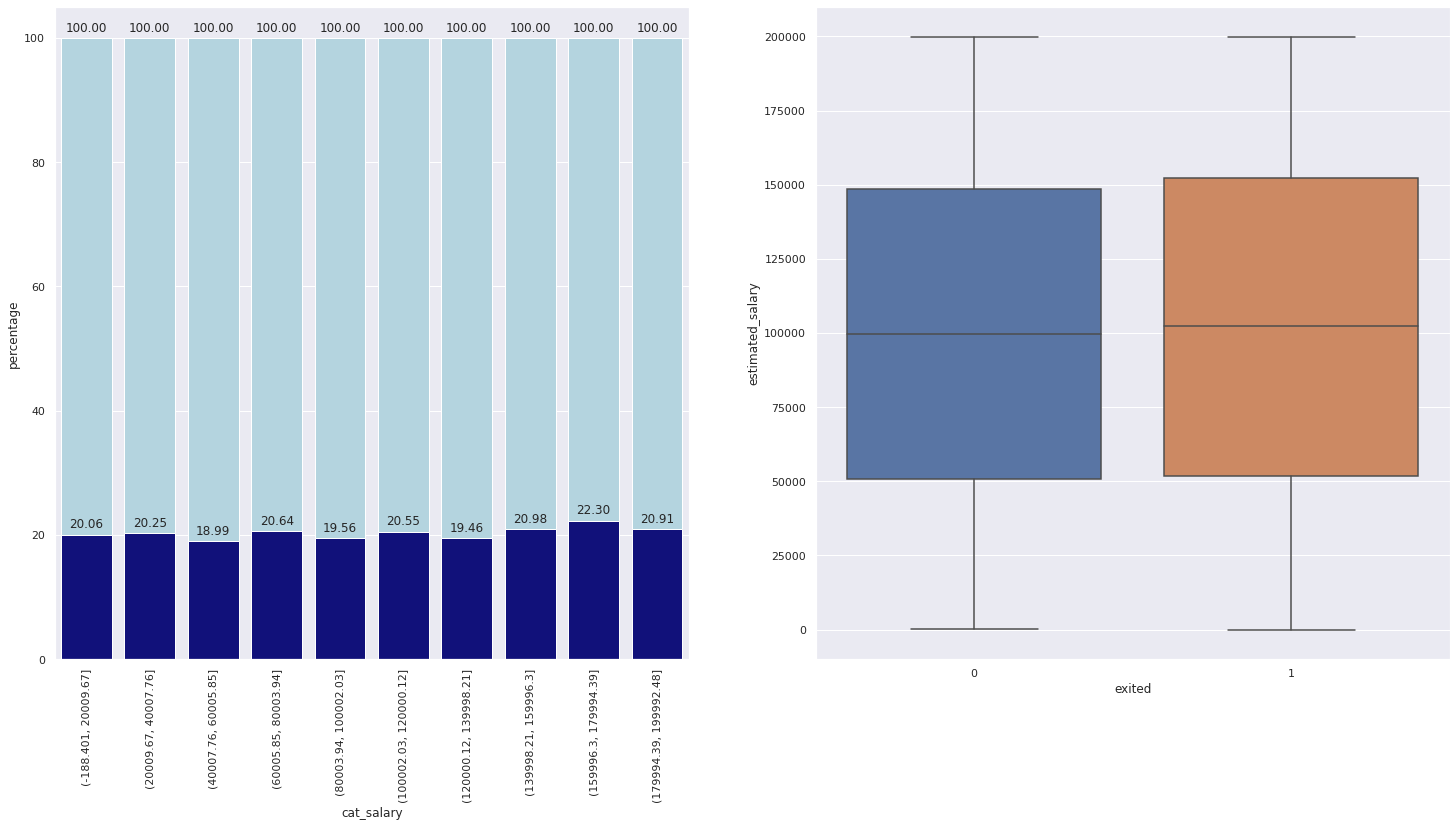

In [67]:
grid = plt.GridSpec(1, 2)

plt.subplot(grid[0, 0])

# plot percentage bar of each value for score_class
bar1 = sns.barplot(x=aux_4['index'], y=aux_4[0], color='lightblue')
bar2 = sns.barplot(x=aux_3.index, y=round(aux_3['percentage'], 2), color='darkblue', order = aux_3.index)
plt.xticks(rotation=90)

# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

# plot boxplot of salary and exited
plt.subplot(grid[0, 1])
sns.boxplot(x=df3['exited'], y=df3['estimated_salary'])

### H11. Customers with a high amount of money in account tend to evaded less (exclude 0) - FALSE
- The distribution of balance amounts is similar in both cases. The median age is the same.

In [68]:
# create aux with only values balance > 0
aux = df3.loc[df3['balance'] > 0, :]

In [69]:
# creating aux that groups exited and balance by mean
aux_2 = aux[['balance', 'exited']].groupby('exited').mean().reset_index()

In [70]:
# create aux crosstab balance and exited
aux_3 = pd.crosstab(aux['balance'], aux['exited'])
aux_3['percentage'] = aux_3[1] / (aux_3[0] + aux_3[1]) * 100

In [71]:
# select only exited values = 1
aux_4 = aux_3.loc[aux_3[1] == 1, :].reset_index()

<AxesSubplot:xlabel='exited', ylabel='balance'>

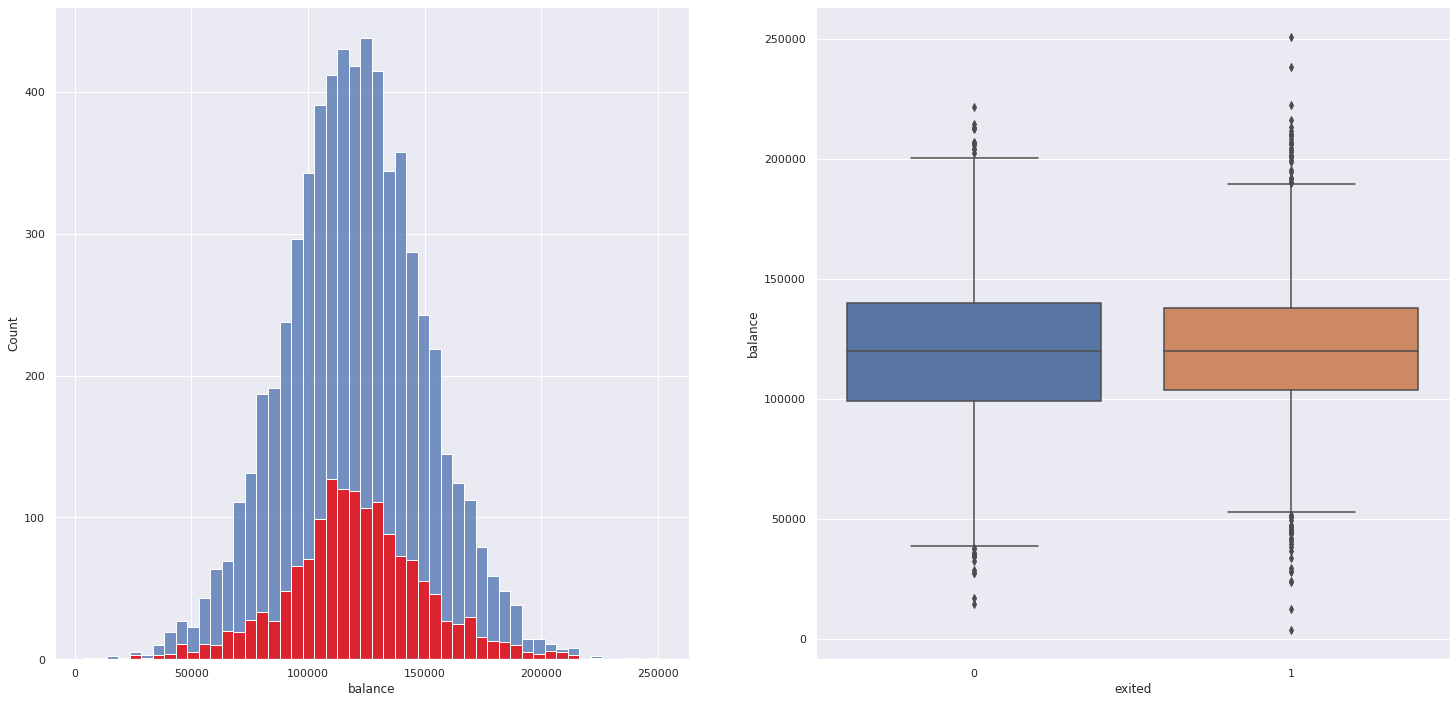

In [72]:
grid = plt.GridSpec(1, 2)

plt.subplot(grid[0, 0])
sns.histplot(x=aux['balance'], bins=50)
sns.histplot(x=aux_4['balance'], color='red', bins=50)

plt.subplot(grid[0, 1])
sns.boxplot(x=aux['exited'], y=aux['balance'])

### H12. Customer with any value in account tend to evaded less - FALSE
In the data, people with values in account evade more.

In [73]:
# create aux
aux = pd.crosstab(df3['have_balance'], df3['exited'])#.reset_index()
aux['percentage'] = aux[1] / (aux[0] + aux[1]) * 100

In [74]:
# create aux_2 dataframe
aux_2 = pd.DataFrame({k:100 for k in range(0, 2)}, index=[0]).T.reset_index()

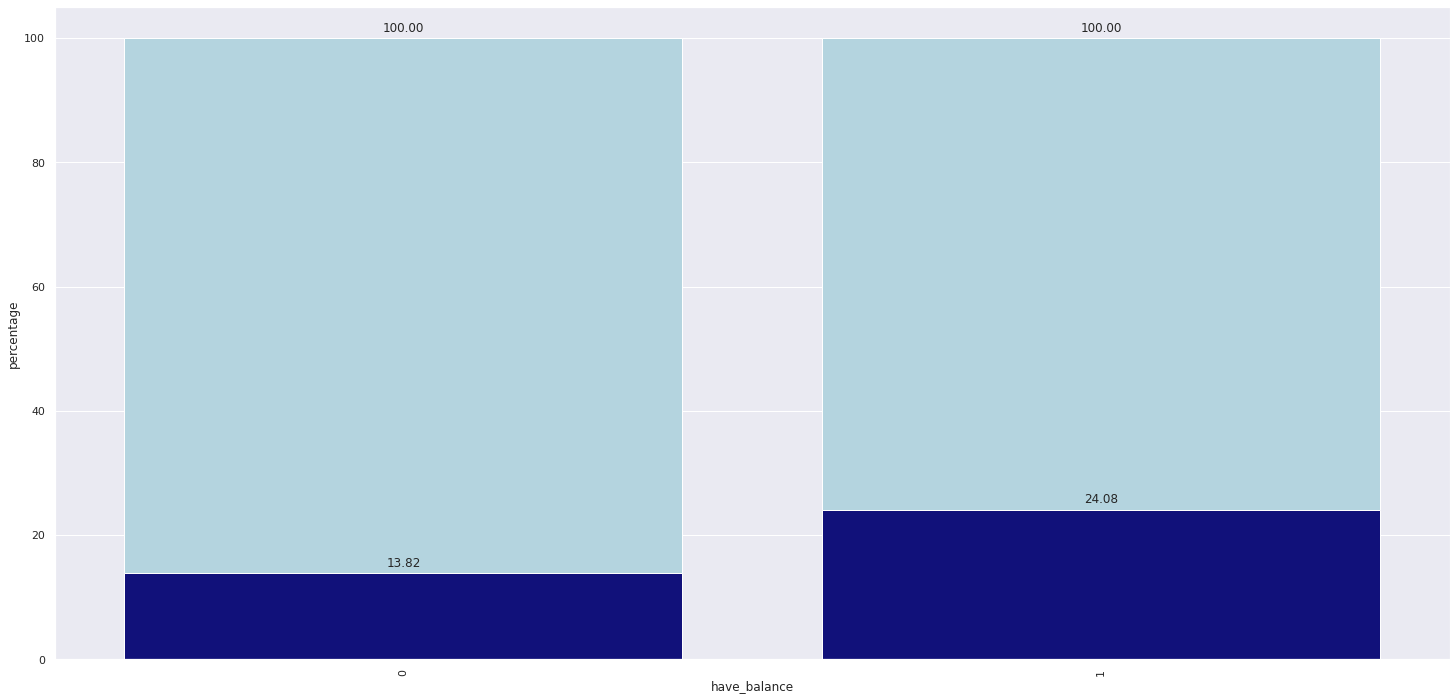

In [75]:
# plot percentage bar of each value for have_balance
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=round(aux['percentage'], 2), color='darkblue', order = aux.index)
plt.xticks(rotation=90)

# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

### H13. Customers with a high score and low amount of money on account tend to evaded more - FALSE
- For any score level, customers who evade have a higher account money average.

In [76]:
# create aux DafaFrame
aux = df3[['exited', 'score_class', 'balance']].groupby(['score_class', 'exited']).mean().reset_index()

<AxesSubplot:xlabel='score_class', ylabel='balance'>

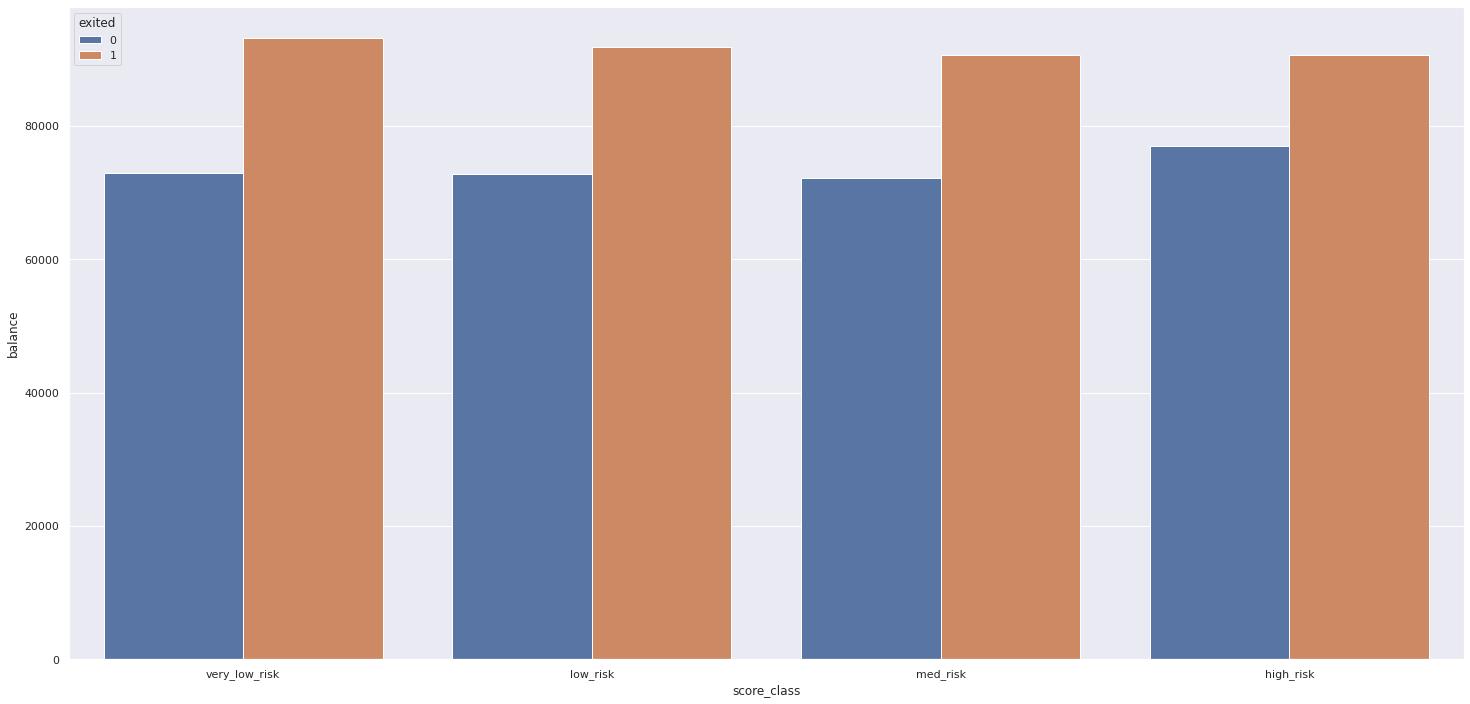

In [77]:
# plot barplot
sns.barplot(x='score_class', y='balance', hue='exited', data=aux, order=['very_low_risk', 'low_risk', 'med_risk', 'high_risk'])

### H14. People with a high salary and a low amount of money on account tend to evaded more - FALSE
For any salary level, clients who evade have a higher average cash account.

In [78]:
# create a final aux DataFrame to plot
aux = df3[['exited', 'cat_salary', 'balance']].groupby(['cat_salary', 'exited']).mean().reset_index()

<AxesSubplot:xlabel='cat_salary', ylabel='balance'>

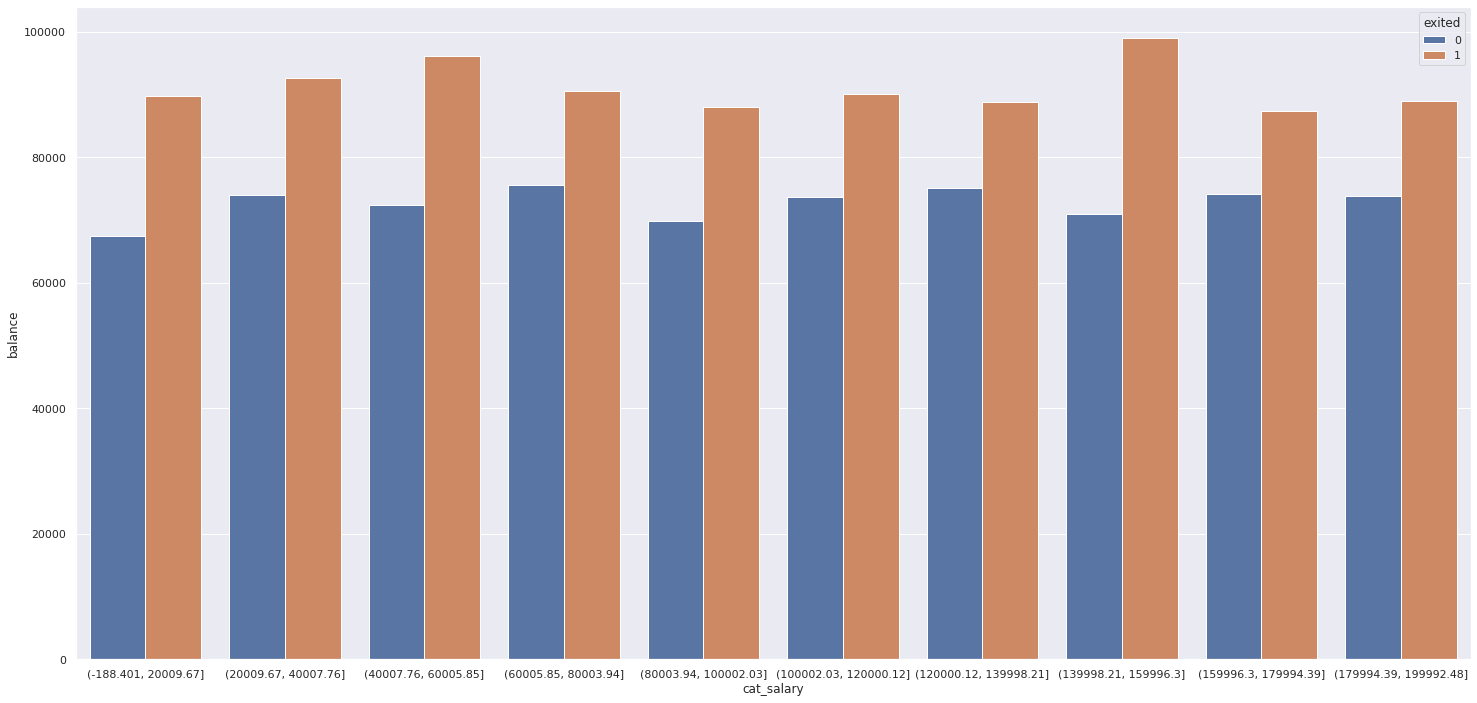

In [79]:
# plot
sns.barplot(x='cat_salary', y='balance', hue='exited', data=aux)

### H15. Non-active customers who do not have a credit card tend to evade more than non-active customers with a credit card - FALSE
No correlation between these variables

In [80]:
# create a crosstab and percentage values
aux = pd.crosstab(df3['exited'], [df3['is_active_member'], df3['has_cr_card']]).T.reset_index()
aux['percentage'] = aux[1] / (aux[0] + aux[1]) * 100

In [81]:
# select only non-active customers
aux_2 = aux.loc[aux['is_active_member'] == 0, 'percentage']

In [82]:
# create bars 100
aux_3 = pd.DataFrame({k:100 for k in range(0, 2)}, index=[0]).T.reset_index()

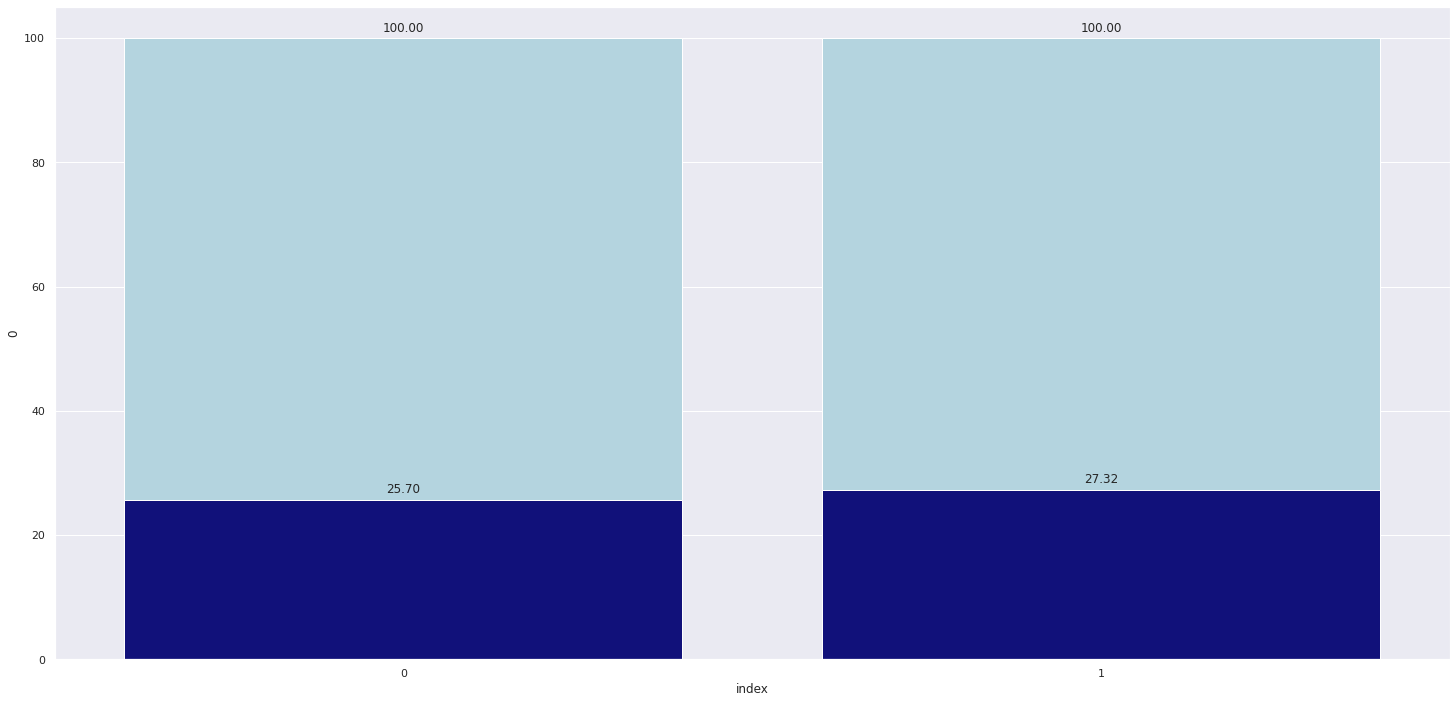

In [83]:
# plot percentage bar of each value for credit_card value for non-active members
bar1 = sns.barplot(x=aux_3['index'], y=aux_3[0], color='lightblue')
bar2 = sns.barplot(x=aux_2.index, y=aux_2.values, color='darkblue', order = aux_2.index)


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

### H16. Younger credit card customers tend to evade less than Younger no credit card customers - FALSE
No correlation between these variables

In [84]:
# create a crosstab and percentage values
aux = pd.crosstab(df3['exited'], [df3['age_category'], df3['has_cr_card']]).T.reset_index()
aux['percentage'] = aux[1] / (aux[0] + aux[1]) * 100

In [85]:
# select only customers with age 18 - 29
aux_2 = aux.loc[aux['age_category'] == '18 - 29', 'percentage']

In [86]:
# create bars 100
aux_3 = pd.DataFrame({k:100 for k in range(0, 2)}, index=[0]).T.reset_index()

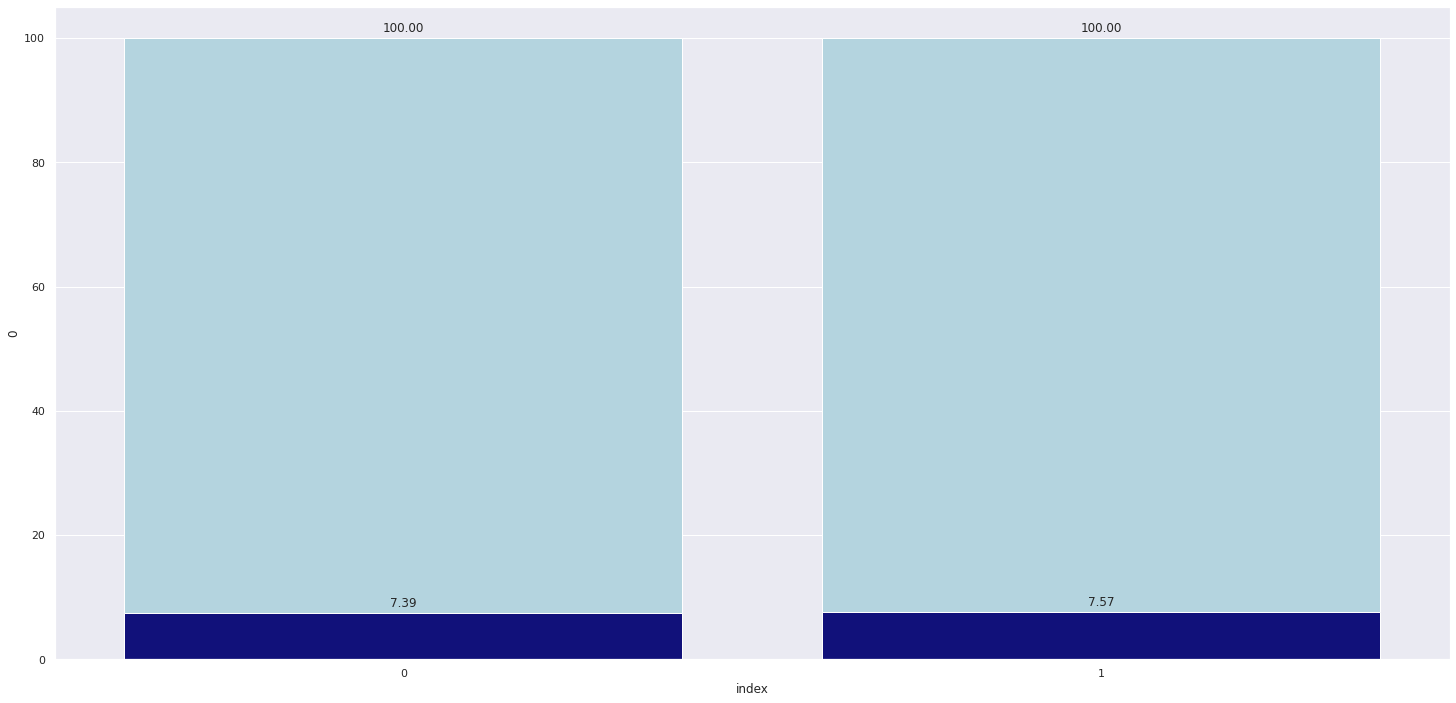

In [87]:
# plot percentage bar of each value for credit_card value for age 18 - 29
bar1 = sns.barplot(x=aux_3['index'], y=aux_3[0], color='lightblue')
bar2 = sns.barplot(x=aux_2.index, y=aux_2.values, color='darkblue', order = aux_2.index)


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

### H17. People who have spent a higher percentage of life as a customer tend to evade less - TRUE
The average customer lifetime percentage is higher for those who have not dropped out. However, the difference is minimal and perhaps not relevant.

In [88]:
# create aux groupby DataFrame with perc_tenure and exited
aux = df3[['perc_tenure', 'exited']].groupby('exited').mean().reset_index()
aux['perc_tenure'] = aux['perc_tenure'] * 100

In [89]:
# create bars 100
aux_2 = pd.DataFrame({k:100 for k in range(0, 2)}, index=[0]).T.reset_index()

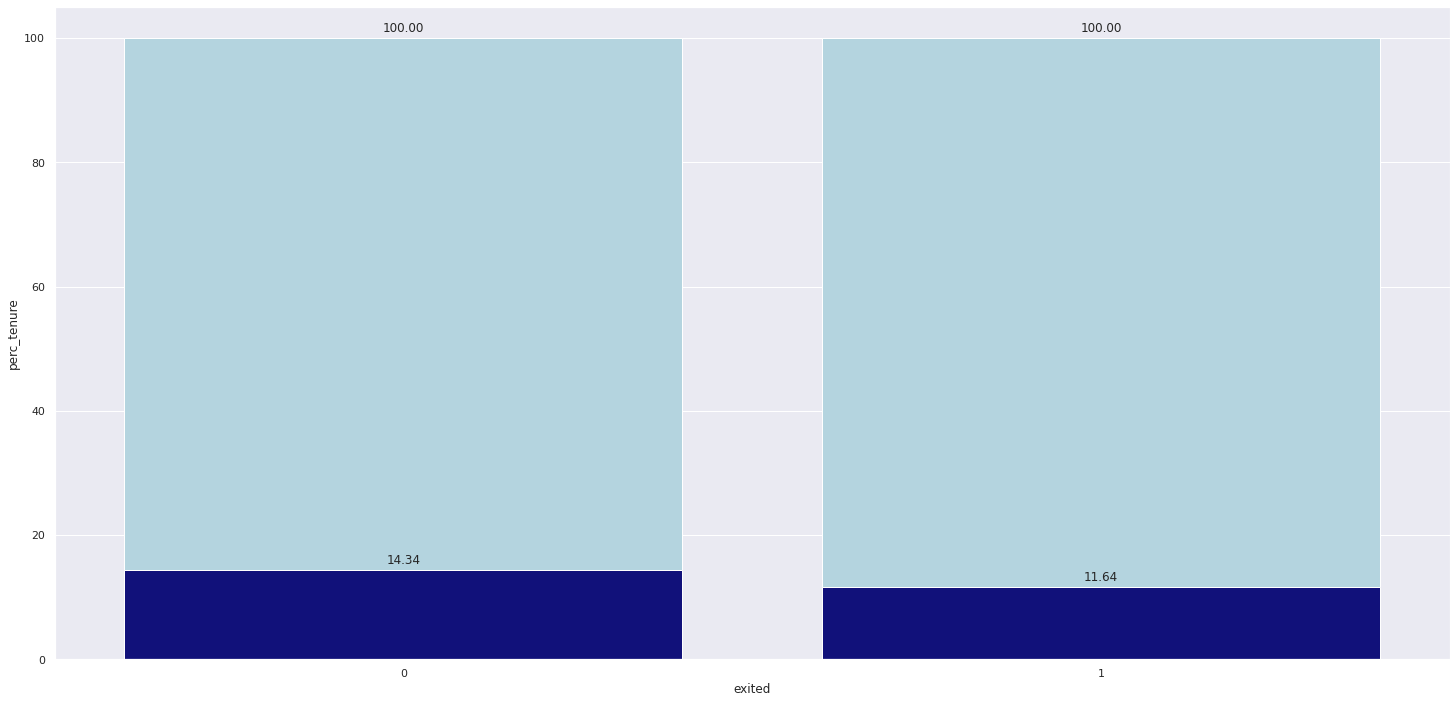

In [90]:
# plot percentage bar
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux['exited'], y=aux['perc_tenure'], color='darkblue')


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

## 3.3. Multivariate Analysis

### 3.3.1. Separating

**Categoric**:
- geography
- gender
- cat_salary
- age_category
- score_class

**Numerical**:
- credit_score
- age
- balance
- tenure
- num_of_products
- estimated_salary
- perc_tenure
- score_account

**Binary**
- has_cr_card
- is_active_member
- have_balance

**Target**
- exited

In [91]:
# categorical variables
cat_vars = df3.loc[:, ['geography', 'gender', 'cat_salary',
                       'age_category', 'score_class', 'has_cr_card',
                       'is_active_member', 'have_balance']
                  ]

# numerical variables
num_vars = df3.loc[:, ['credit_score', 'age', 'balance', 'tenure',
                       'num_of_products', 'estimated_salary', 'perc_tenure',
                       'score_account']
                  ]

### 3.3.2 Correlation between numerical attributes

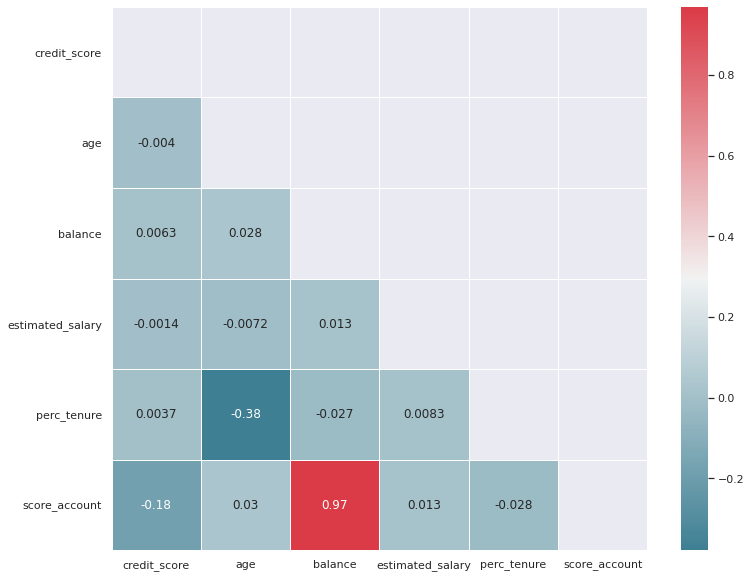

In [92]:
# calculate correlations
correlations = num_vars.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 10)

# generates a mask for the upper triangle
mask = np.triu(np.ones_like(correlations))

# generates a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plots the heatmap
sns.heatmap(correlations, cmap=cmap, mask=mask, linewidths=.5, annot=True)

# displays the plot
plt.show()

- 0.97 - **balance** and **score_account** are highly correlated. As expected, as one is derived from the other.

### 3.3.3 Correlation between categorical attributes

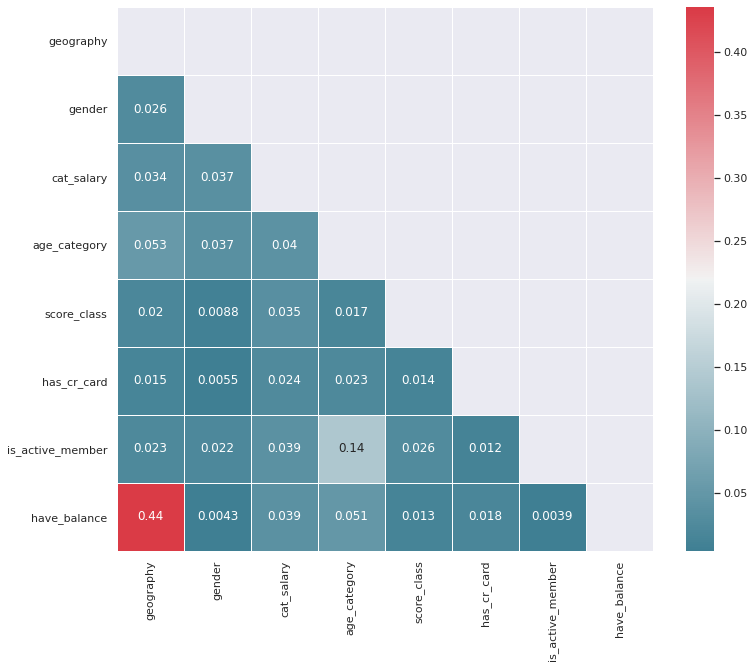

In [93]:
# calculate correlations
cat = {}

for value in cat_vars.columns:
    cols = []
    for value_ in cat_vars.columns:
        cols.append(cramer_v(cat_vars[value], cat_vars[value_]))
        
    cat[value] = cols
    
d = pd.DataFrame(cat)

d = d.set_index(d.columns)

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 10)

# generates a mask for the upper triangle
mask = np.triu(d)

# generates a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plots the heatmap
sns.heatmap(d, cmap=cmap, mask=mask, linewidths=.5, annot=True)

# displays the plot
plt.show()

# 4.0. DATA PREPARATION

In [94]:
df4 = df3.copy()

## 4.1. Encoding Dataset

In [95]:
# geography -> OneHotEncoding
df4 = pd.get_dummies(df4, prefix='geography', columns=['geography'])

# gender -> OneHotEncoding
df4 = pd.get_dummies(df4, prefix='gender', columns=['gender'], drop_first=True)

# score_class -> OrdinalEncoding
score_class_dict = {'high_risk': 0, 'med_risk': 1, 'low_risk': 2, 'very_low_risk': 3}
df4['score_class'] = df4['score_class'].map(score_class_dict)

# cat_salary -> OrdinalEncoding
cat_salary_dict = {'(-188.401, 20009.67]': 0, '(20009.67, 40007.76]': 1,
                    '(40007.76, 60005.85]': 2, '(60005.85, 80003.94]': 3, 
                    '(80003.94, 100002.03]':4, '(100002.03, 120000.12]':5,
                    '(120000.12, 139998.21]':6, '(139998.21, 159996.3]':7,
                    '(159996.3, 179994.39]':8, '(179994.39, 199992.48]':9}

df4['cat_salary'] = df4['cat_salary'].astype('str')
df4['cat_salary'] = df4['cat_salary'].map(cat_salary_dict)

# age_category -> OrdinalEncoding
age_category_dict = {'18 - 29': 0, '30 - 39': 1, '40 - 49': 2, '50 - 59': 3, '60 +':4}
df4['age_category'] = df4['age_category'].map(age_category_dict)

## 4.2. Split Dataset

In [96]:
# separate variable response
X = df4.drop('exited', axis=1)
y = df4.loc[:, 'exited']

# split dataset in train and test
X_train, X_test, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=32, stratify=y)

# transform y into int
y_train = y_train_.astype('int64')
y_test = y_test_.astype('int64')

X_test_full = pd.merge(X_test, y_test, left_index=True, right_index=True)

## 4.3. Scalling Dataset

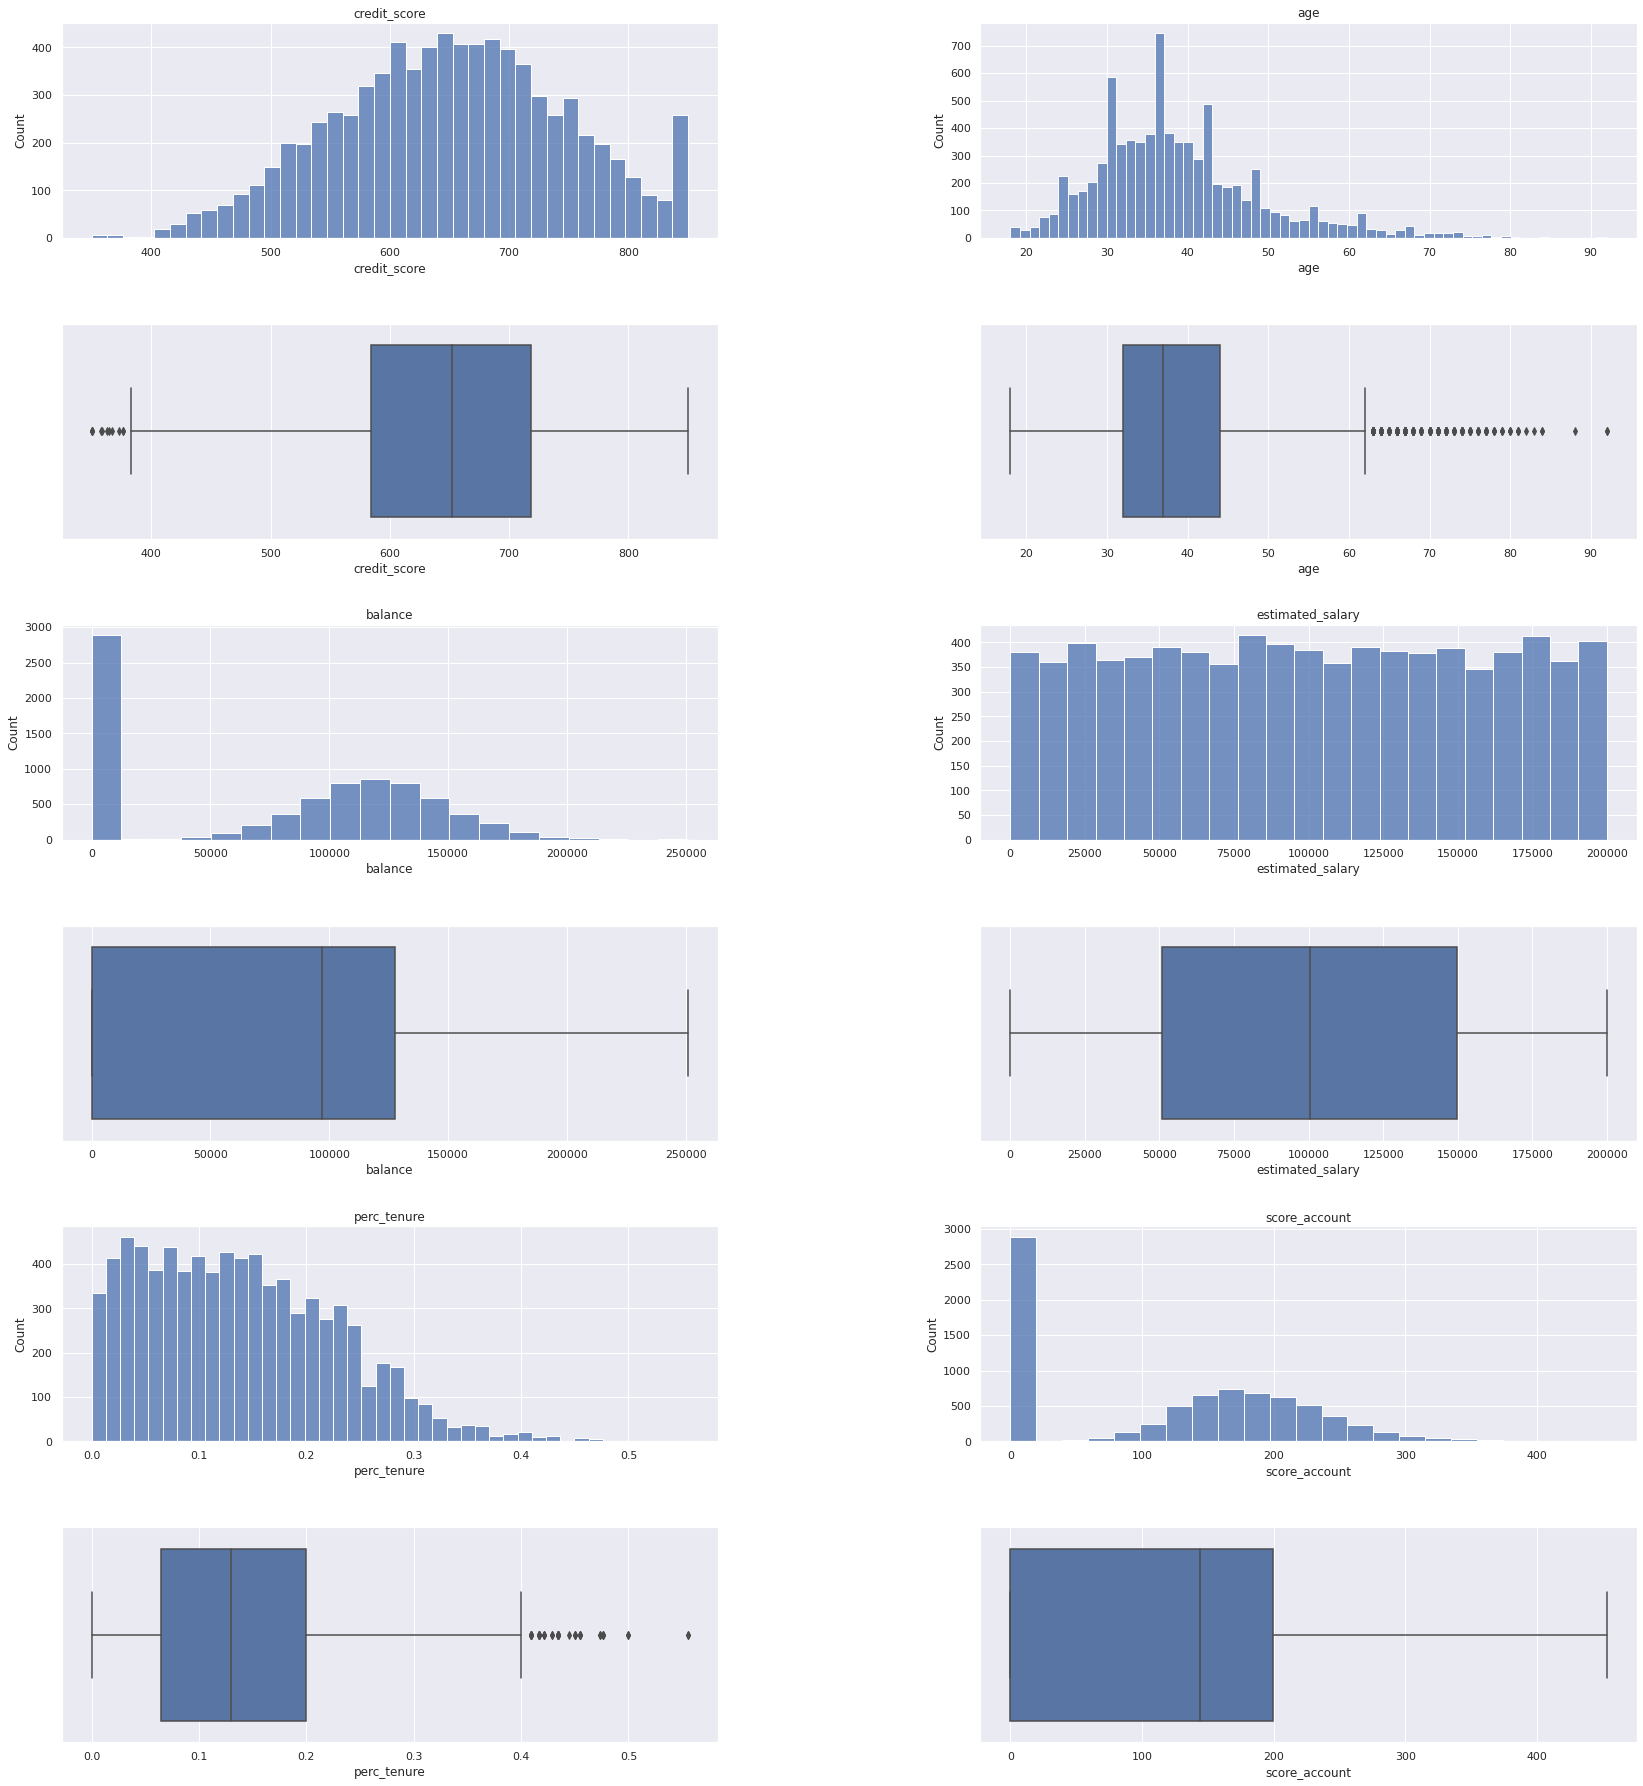

In [97]:
grid = plt.GridSpec(6, 2)

# credit_score
plt.subplot(grid[0, 0])
sns.histplot(X_train['credit_score'])

plt.title('credit_score')

plt.subplot(grid[1, 0])
sns.boxplot(x = X_train['credit_score'])

# age
plt.subplot(grid[0, 1])
sns.histplot(X_train['age'])

plt.title('age')

plt.subplot(grid[1, 1])
sns.boxplot(x = X_train['age'])

# balance
plt.subplot(grid[2, 0])
sns.histplot(X_train['balance'])

plt.title('balance')

plt.subplot(grid[3, 0])
sns.boxplot(x = X_train['balance'])

# estimated_salary
plt.subplot(grid[2, 1])
sns.histplot(X_train['estimated_salary'])

plt.title('estimated_salary')

plt.subplot(grid[3, 1])
sns.boxplot(x = X_train['estimated_salary'])

# perc_tenure
plt.subplot(grid[4, 0])
sns.histplot(X_train['perc_tenure'])

plt.title('perc_tenure')

plt.subplot(grid[5, 0])
sns.boxplot(x = X_train['perc_tenure'])

# score_account
plt.subplot(grid[4, 1])
sns.histplot(X_train['score_account'])

plt.title('score_account')

plt.subplot(grid[5, 1])
sns.boxplot(x = X_train['score_account'])


plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=1, 
                    top=2, 
                    wspace=0.4, 
                    hspace=0.40)

MinMaxScaler:
- credit_score
- estimated_salary

RobustScaler:
- age
- balance
- perc_tenure
- score_account

In [98]:
# scalers
mms = pp.MinMaxScaler()
rs = pp.RobustScaler()

In [99]:
# credit_score -> MinMaxScaler
mms_credit_score_train = mms.fit(X_train[['credit_score']].values)
mms_credit_score_test = mms.fit(X_test[['credit_score']].values)
X_train['credit_score'] = mms_credit_score_train.transform(X_train[['credit_score']].values)
X_test['credit_score'] = mms_credit_score_test.transform(X_test[['credit_score']].values)

# estimated_salary -> MinMaxScaler
mms_estimated_salary_train = mms.fit(X_train[['estimated_salary']].values)
mms_estimated_salary_test = mms.fit(X_test[['estimated_salary']].values)
X_train['estimated_salary'] = mms_estimated_salary_train.transform(X_train[['estimated_salary']].values)
X_test['estimated_salary'] = mms_estimated_salary_test.transform(X_test[['estimated_salary']].values)

# age -> RobustScaler
rs_age_train = rs.fit(X_train[['age']].values)
rs_age_test = rs.fit(X_test[['age']].values)
X_train['age'] = rs_age_train.transform(X_train[['age']].values)
X_test['age'] = rs_age_test.transform(X_test[['age']].values)

# balance -> RobustScaler
rs_balance_train = rs.fit(X_train[['balance']].values)
rs_balance_test = rs.fit(X_test[['balance']].values)
X_train['balance'] = rs_balance_train.transform(X_train[['balance']].values)
X_test['balance'] = rs_balance_test.transform(X_test[['balance']].values)

# perc_tenure -> RobustScaler
rs_perc_tenure_train = rs.fit(X_train[['perc_tenure']].values)
rs_perc_tenure_test = rs.fit(X_test[['perc_tenure']].values)
X_train['perc_tenure'] = rs_perc_tenure_train.transform(X_train[['perc_tenure']].values)
X_test['perc_tenure'] = rs_perc_tenure_test.transform(X_test[['perc_tenure']].values)

# score_account -> RobustScaler
rs_score_account_train = rs.fit(X_train[['score_account']].values)
rs_score_account_test = rs.fit(X_test[['score_account']].values)
X_train['score_account'] = rs_score_account_train.transform(X_train[['score_account']].values)
X_test['score_account'] = rs_score_account_test.transform(X_test[['score_account']].values)

# 5.0. Feature Selection

## 5.1. Boruta as Feature Selector

In [100]:
# select X and y train values
X_train_nn = X_train.values
y_train_nn = y_train.values.ravel()

### 5.1.1. Boruta with ExtraTreesClassifier

In [101]:
# instantiate ExtraTreesClassifier
etc = en.ExtraTreesClassifier(n_jobs=-1)

# fit boruta with ExtraTreesClassifier
boruta_etc = BorutaPy(etc, n_estimators='auto', verbose=0, random_state=32).fit(X_train_nn, y_train_nn)

# col selected or not
cols_selected_etc = boruta_etc.support_.tolist()

# columns selected by boruta
cols_selected_boruta_etc = X_train.iloc[:, cols_selected_etc].columns.to_list()

# show the columns
cols_selected_boruta_etc

['age', 'num_of_products', 'is_active_member', 'perc_tenure', 'age_category']

### 5.1.2. Boruta with XGBoost

In [102]:
# instantiate XGBoostRegressor
xgb = xgboost.XGBRegressor(n_jobs=-1)

# fit boruta with XGBoostRegressor
boruta_xgb = BorutaPy(xgb, n_estimators='auto', verbose=0, random_state=32).fit(X_train_nn, y_train_nn)

# col selected or not
cols_selected_xgb = boruta_xgb.support_.tolist()

# columns selected by boruta
cols_selected_xgb = X_train.iloc[:, cols_selected_xgb].columns.to_list()

# show the columns
cols_selected_xgb

['age',
 'balance',
 'num_of_products',
 'is_active_member',
 'score_account',
 'geography_Germany',
 'gender_Male']

## 5.2. Manual Feature Selection

<AxesSubplot:>

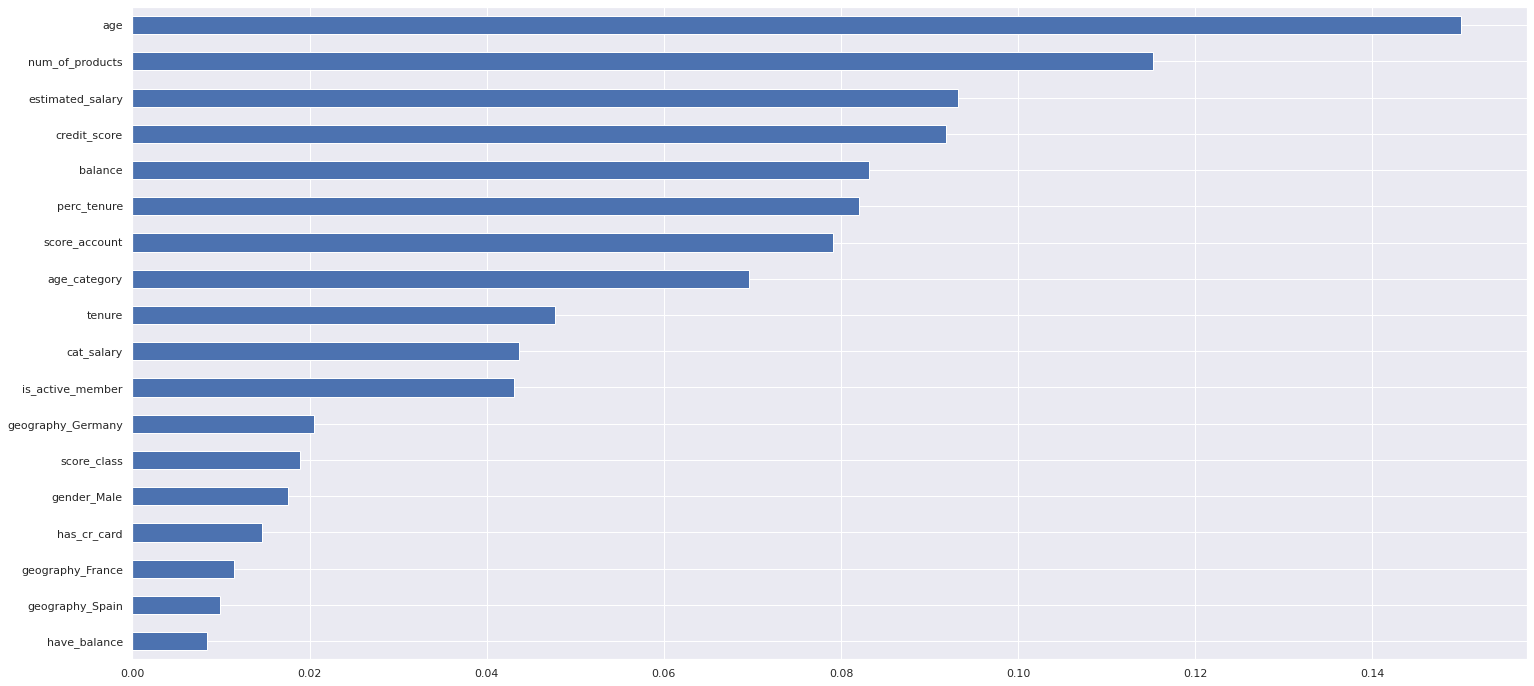

In [103]:
# instantiate RandomForestClassifier
rf_model = en.RandomForestClassifier(n_jobs = -1)

# fit RandomForestClassifier model with X_train and y_train
rf_model.fit(X_train, y_train)

# feature importances
feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# plot feature importances
feat_importances.sort_values().plot(kind='barh')

## 5.3. Recursive Feature Elimination (RFE)

In [104]:
# instantiate RFE
rfe = RFE(estimator=rf_model, n_features_to_select=10)

# train RFE with X_train and y_train
fit = rfe.fit(X_train, y_train)

# show values
for i in range(X_train.shape[1]):
    print('{} - Rank: {}'.format(X_train.columns[i], rfe.ranking_[i]))

credit_score - Rank: 1
age - Rank: 1
tenure - Rank: 1
balance - Rank: 1
num_of_products - Rank: 1
has_cr_card - Rank: 6
is_active_member - Rank: 2
estimated_salary - Rank: 1
perc_tenure - Rank: 1
score_account - Rank: 1
score_class - Rank: 4
age_category - Rank: 1
have_balance - Rank: 9
cat_salary - Rank: 1
geography_France - Rank: 7
geography_Germany - Rank: 3
geography_Spain - Rank: 8
gender_Male - Rank: 5


## 5.4. Features Final List

In [105]:
# Features selected
features = ['age', 'num_of_products', 'perc_tenure', 'estimated_salary', 'credit_score', 
            'balance', 'geography_Germany', 'is_active_member']

# Select features in datasets
X_train_feat = X_train[features]
X_test_feat = X_test[features]

In [106]:
# change dtypes - num_of_products
X_train_feat['num_of_products'] = X_train_feat['num_of_products'].astype('int64')
X_test_feat['num_of_products'] = X_test_feat['num_of_products'].astype('int64')

# change dtypes - is_active_member
X_train_feat['is_active_member'] = X_train_feat['is_active_member'].astype('int64')
X_test_feat['is_active_member'] = X_test_feat['is_active_member'].astype('int64')

# 6.0. Machine Learning Modeling

## 6.1. Train Models

In [107]:
# list of models to show performance in train dataset
list_models = [lm.LogisticRegression(random_state=32),
               nhb.KNeighborsClassifier(),
               nb.GaussianNB(), 
               LGBMClassifier(n_jobs=-1, random_state=32),
               en.RandomForestClassifier(n_jobs =-1, random_state=32), 
               cb.CatBoostClassifier(verbose=0, random_state=32),
               xgboost.XGBClassifier(n_jobs=-1, objective='binary:logistic',
                                     use_label_encoder=False, verbosity=0, random_state=32)
               ]

In [108]:
# select all models of list and X_train/y_train to calculate performance in cross validation
ml = PerformanceView(list_models, X_train_feat, y_train, n_splits=5, threshold=0.50)

In [109]:
# calcule performance in cross validation
ml.performance(oversample = True, random_state=32)

Training LogisticRegression...
Training KNeighborsClassifier...
Training GaussianNB...
Training LGBMClassifier...
Training RandomForestClassifier...
Training CatBoostClassifier...
Training XGBClassifier...


In [110]:
# show table with al performance models
ml.final_df

,accuracy,precision,recall,f1,kappa,roc_auc
LogisticRegression,0.7129 +/- 0.0138,0.3851 +/- 0.0188,0.6859 +/- 0.0426,0.4932 +/- 0.0252,0.3143 +/- 0.0333,0.7637 +/- 0.0222
KNeighborsClassifier,0.7510 +/- 0.0112,0.4312 +/- 0.0155,0.6945 +/- 0.0253,0.5320 +/- 0.0162,0.3748 +/- 0.0223,0.7900 +/- 0.0115
GaussianNB,0.7227 +/- 0.0205,0.4000 +/- 0.0236,0.7196 +/- 0.0389,0.5141 +/- 0.0255,0.3416 +/- 0.0364,0.7865 +/- 0.0221
LGBMClassifier,0.8426 +/- 0.0145,0.6155 +/- 0.0455,0.6104 +/- 0.0295,0.6126 +/- 0.0249,0.5139 +/- 0.0340,0.8513 +/- 0.0073
RandomForestClassifier,0.8360 +/- 0.0166,0.5969 +/- 0.0474,0.6061 +/- 0.0083,0.6012 +/- 0.0238,0.4980 +/- 0.0351,0.8430 +/- 0.0104
CatBoostClassifier,0.8449 +/- 0.0176,0.6255 +/- 0.0550,0.5988 +/- 0.0337,0.6115 +/- 0.0342,0.5147 +/- 0.0453,0.8512 +/- 0.0096
XGBClassifier,0.8377 +/- 0.0138,0.6079 +/- 0.0416,0.5767 +/- 0.0295,0.5916 +/- 0.0264,0.4905 +/- 0.0348,0.8399 +/- 0.0044


### 6.2. Confusion Matrix

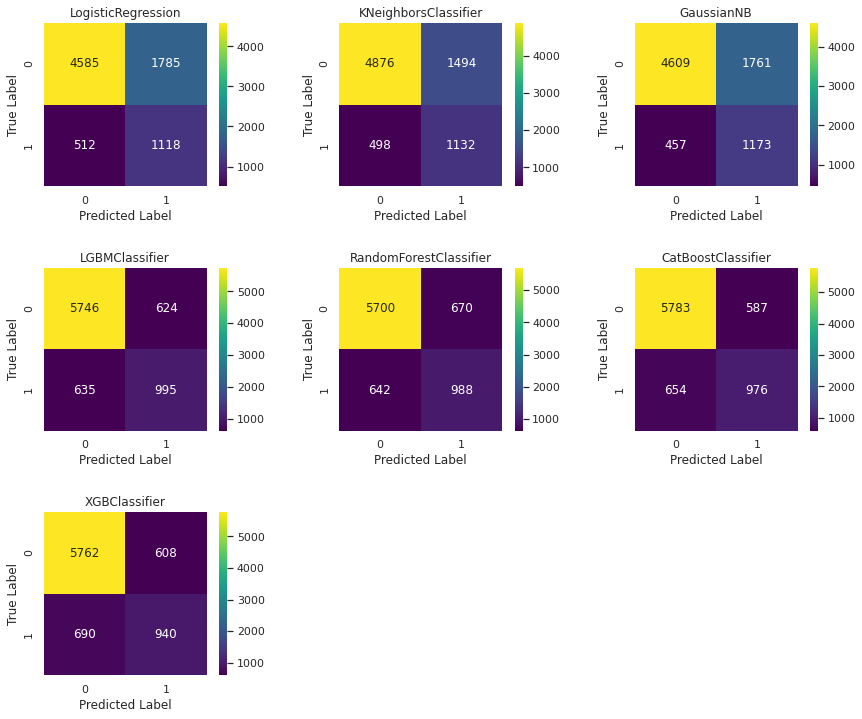

In [111]:
# plot all confusion matrix
ml.plot_cm(3, 3)

## 6.3. Probabilities Distribution

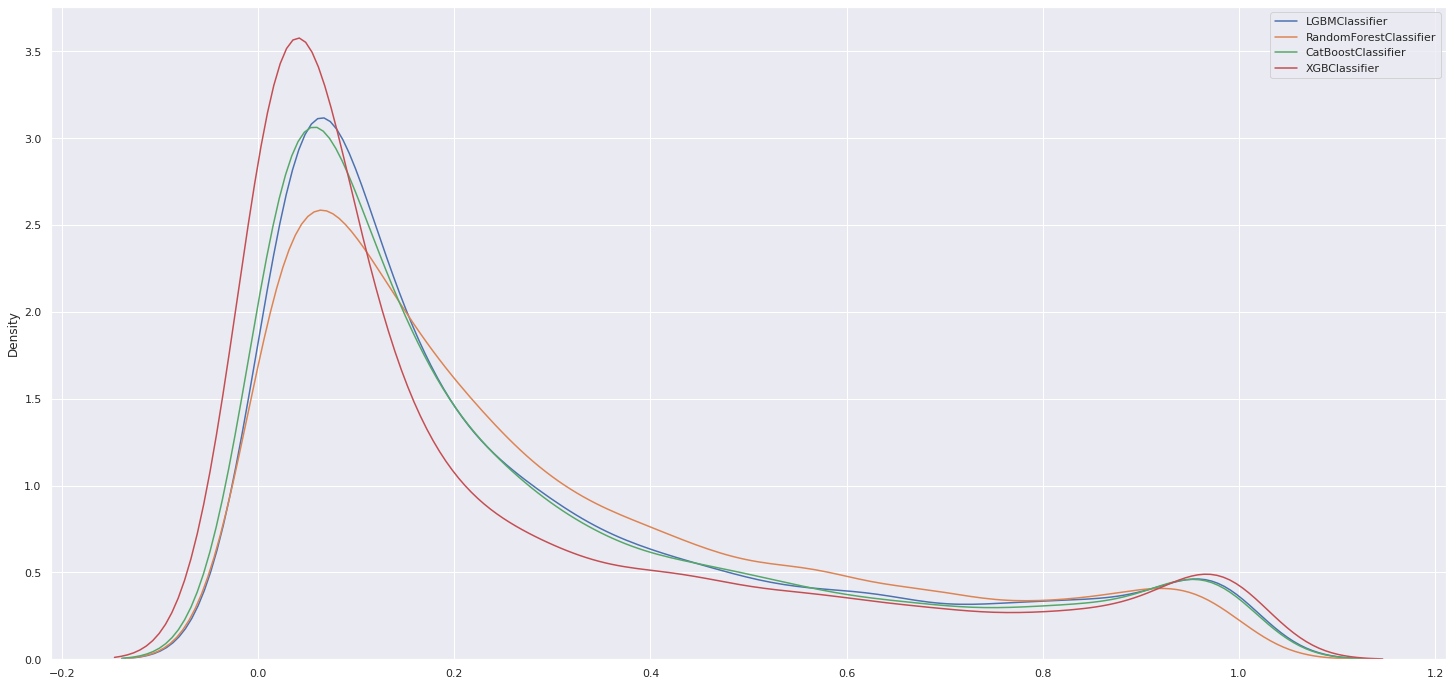

In [112]:
# plot the probabilities distribution of the best models
ml.plot_probas(models=['XGBClassifier', 'RandomForestClassifier', 'CatBoostClassifier', 'LGBMClassifier'])

## 6.4. Curve ROC-AUC

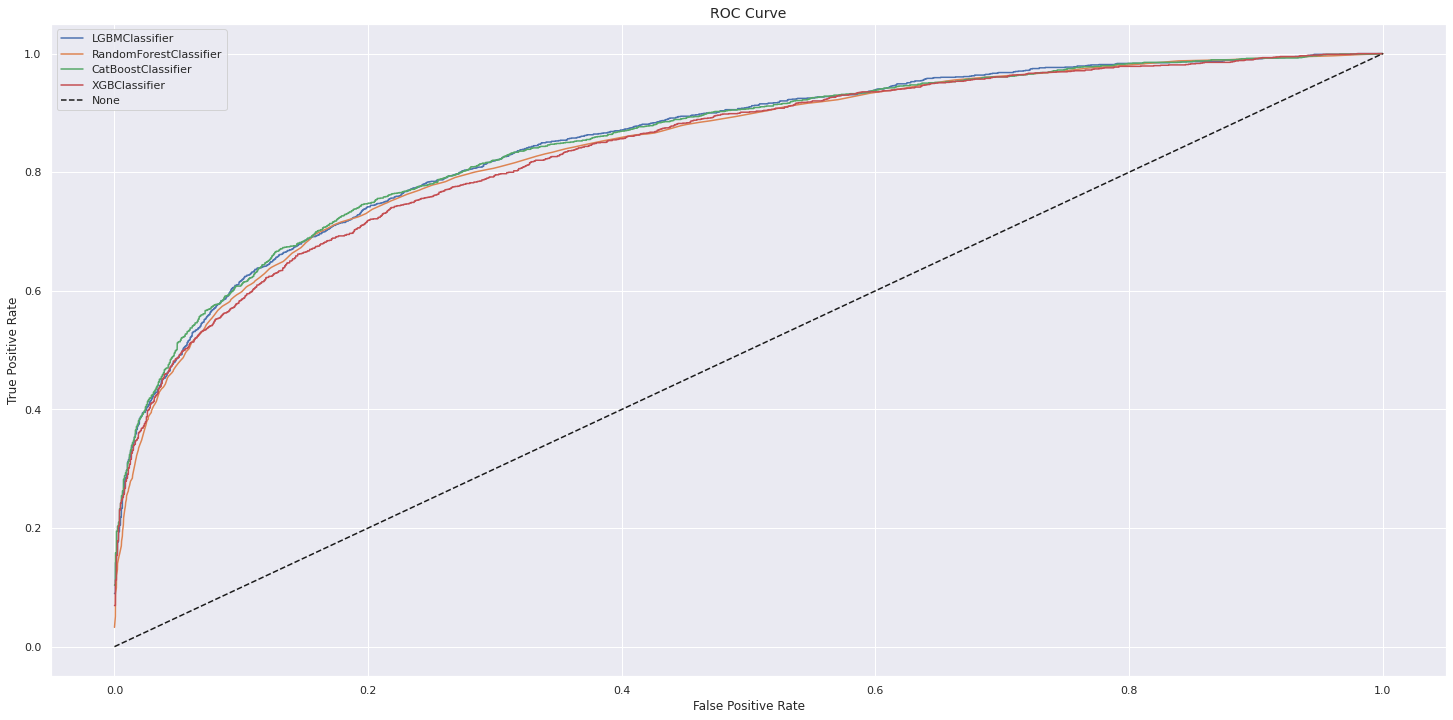

In [113]:
# plot the ROC-AUC of the best models
ml.plot_auc(models=['XGBClassifier', 'RandomForestClassifier', 'CatBoostClassifier', 'LGBMClassifier'])

# 7.0. Tuning Best Model

In [114]:
# select space of hyperparameters
space ={'learning_rate': np.linspace(1e-3, 1e-1, 15),
        'num_leaves': np.linspace(6, 62, 4, dtype='int64'), 
        'min_child_samples': np.linspace(1, 500, 10, dtype='int64'), 
        'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1],
        'subsample': np.linspace(0.05, 1.0, 5),
        'colsample_bytree': np.linspace(0.1, 1, 5)}

In [115]:
#df_tunning  = tune_cv(X_train_feat, y_train, 5, 32, 0.5, 20000)
#df_tunning.iloc[0, :]

In [116]:
# train instanciate LGBMClassifier with tuned hypterparameters
model_tuned = LGBMClassifier(learning_rate=0.071714, num_leaves=6, min_child_samples=278, min_child_weight = 1,
                             subsample=0.7625, colsample_bytree=0.550, random_state=32, n_jobs=-1)

# fit model tuned
performance_model_tuned = PerformanceView([model_tuned], X_train_feat, y_train, n_splits=5, threshold=0.5)

# performances
performance_model_tuned.performance(oversample=True, random_state = 32)

# Select only ROC_AUC
performance_model_tuned.df_performance().loc[:, 'roc_auc']

Training LGBMClassifier...


LGBMClassifier    0.8523 +/- 0.0081
Name: roc_auc, dtype: object

# 8.0. Test Data

In [117]:
# resample with SMOTETomek X_train and y_train to final model
resample_data = SMOTETomek(random_state=32, n_jobs=-1)
X_balanced, y_balanced = resample_data.fit_resample(X_train_feat, y_train)

In [119]:
# fit with balanced dataset
final_model = model_tuned.fit(X_balanced, y_balanced)

# select probas
y_proba = final_model.predict_proba(X_test_feat)[:, 1]

# show roc_auc to test dataset
met.roc_auc_score(y_test, y_proba)

0.8594225967107323

# 9.0. Performance

## 9.1. Model Performance

In [140]:
# precision, recall and threshold for test
precisions, recalls, thresholds = met.precision_recall_curve(y_test, y_proba)

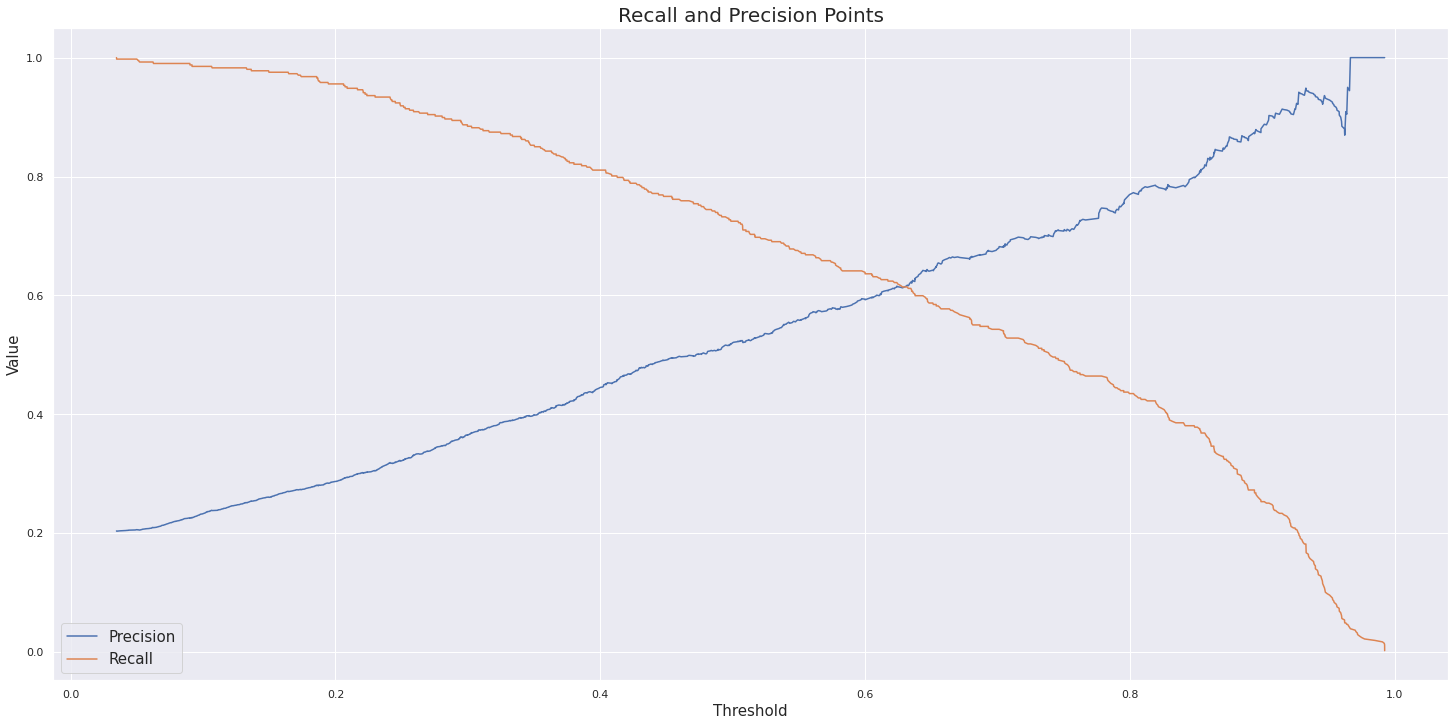

In [141]:
# plot precision line for threshold values
plt.plot(thresholds, precisions[:-1], label='Precision')

# plot recall line for threshold values
plt.plot(thresholds, recalls[:-1], label='Recall')

# text plot
plt.title('Recall and Precision Points', fontsize=20)
plt.xlabel('Threshold', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.legend(fontsize=15)

In [148]:
# fpr, tpr and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

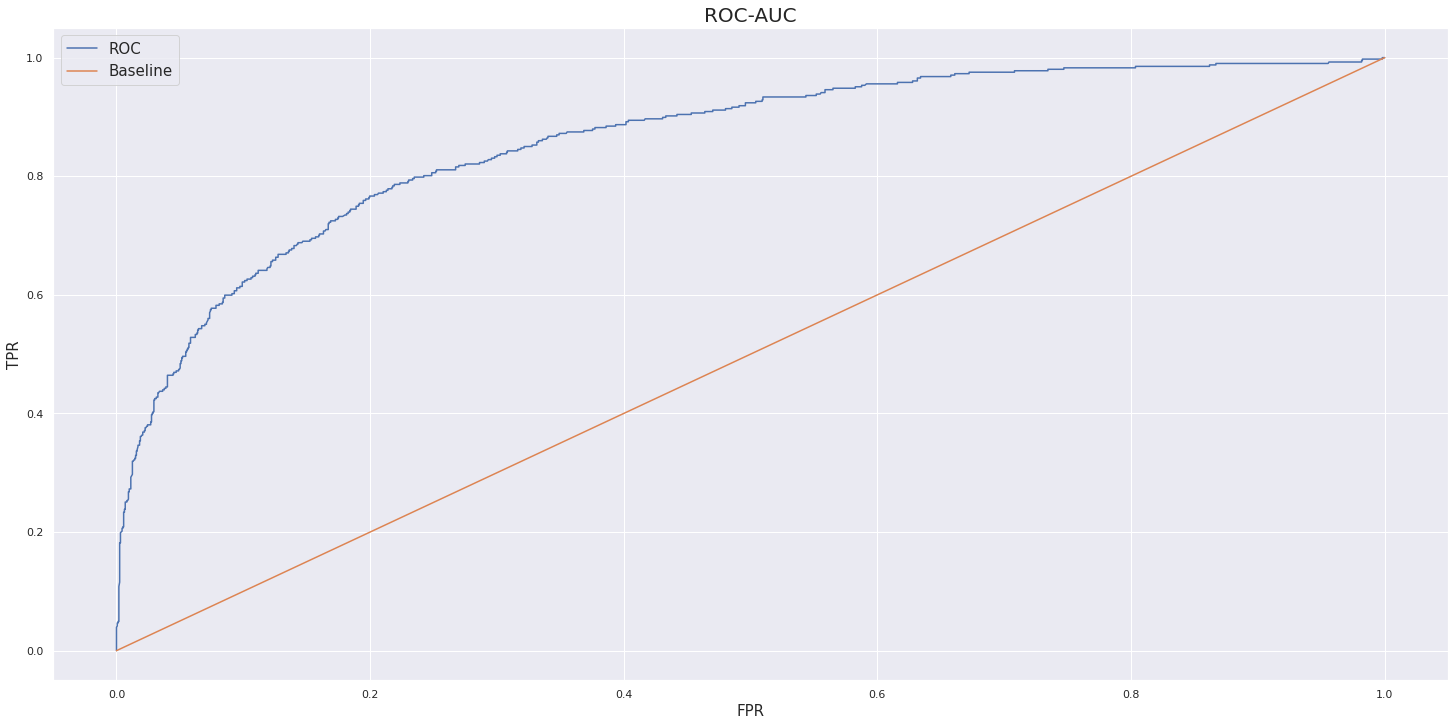

In [149]:
# plot roc
plt.plot(fpr, tpr, label='ROC')

# plot baseline
plt.plot([0, 1], [0, 1], label='Baseline')

# text plot
plt.title('ROC-AUC', fontsize=20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.legend(fontsize=15)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

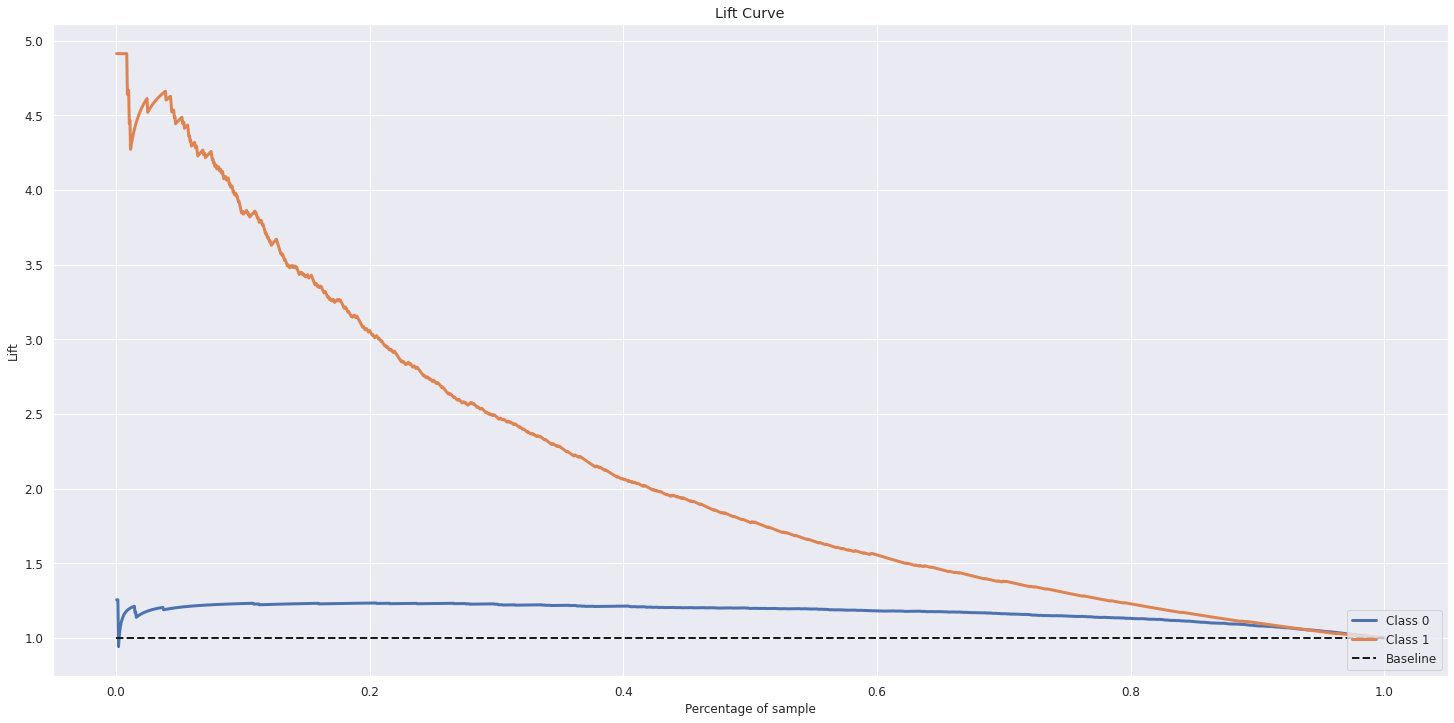

In [155]:
# Calculate probas
y_probas_ = final_model.predict_proba(X_test_feat)

# Plot lif_curve
skplot.metrics.plot_lift_curve(y_test, y_probas_)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

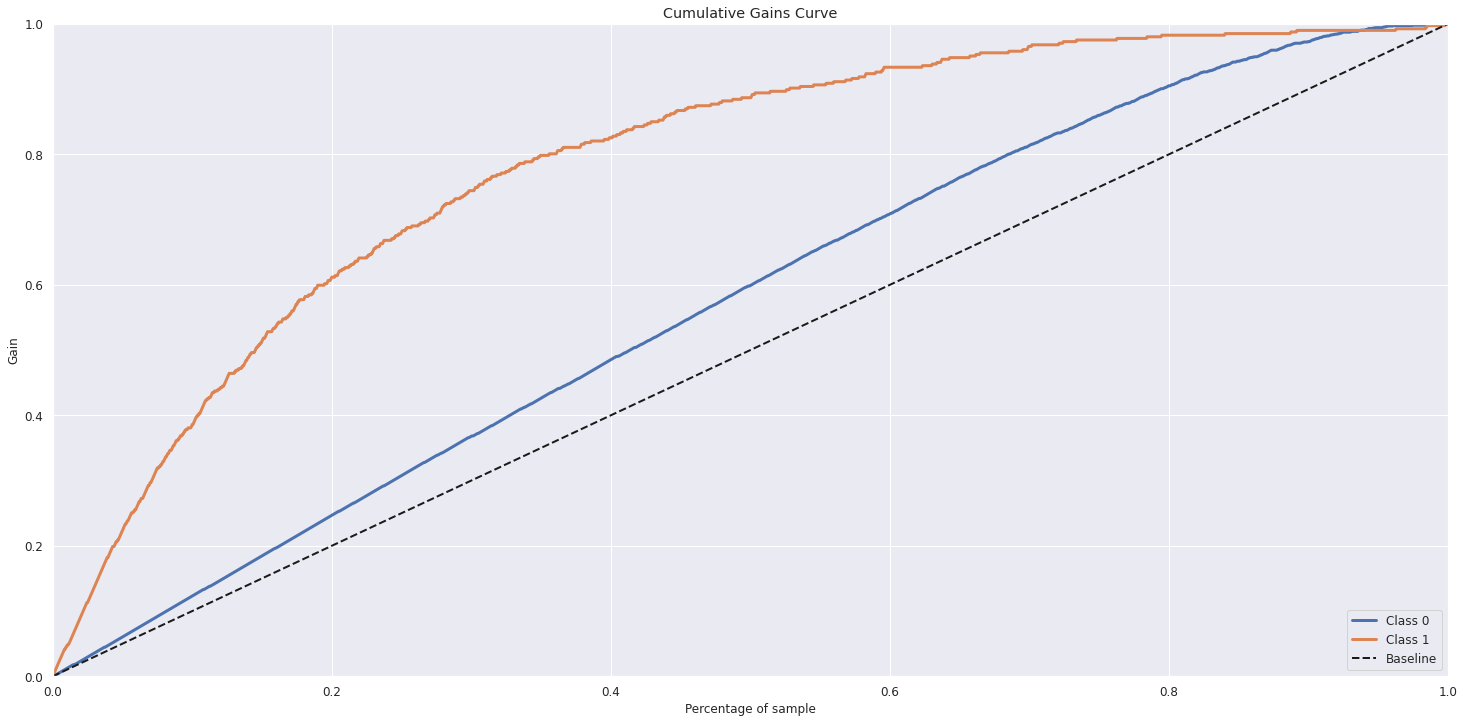

In [156]:
# Plot cumulative gain
skplot.metrics.plot_cumulative_gain(y_test, y_probas_)

## 9.2. Business Performance

## 9.1. Probas

In [157]:
# putting the odds in the dataframe
X_test_full['probas'] = y_proba

# select columns estimated_salary, probas and exited
X_business = X_test_full.loc[:, ['estimated_salary', 'probas', 'exited']]

# calculate return
X_business['return'] = X_business['estimated_salary'].apply(lambda x: x*0.15 if x < X_business['estimated_salary'].mean() else
                                                                      x*0.20)

# Test 1 - Dando 100 cupons aleatórios

In [161]:
list_roi = []
for value in range(0, 10000):
    # Selecionando 100 linhas aleatórias
    X_select = X_business.sample(100)

    # Retorno real (pessoas que não iriam sair não conta como retorno)
    X_select['real_return'] = X_select['return'] * X_select['exited']

    # Retorno final
    final_return = X_select['real_return'].sum()

    # Calculo roi
    roi = round(((final_return - 10000)/10000) * 100, 2)
    
    list_roi.append(roi)

In [174]:
random_roi = round(np.mean(list_roi), 2)

print(f'ROI for random coupon:', random_roi)

ROI for random coupon: 3723.55


# Test 2 - Dando o cupom para as 100 maiores probabilidades

In [168]:
# Selecionando os 100
X_select = X_business.sort_values(by='probas', ascending=False)[:100]

# Retorno real (pessoas que não iriam sair não conta como retorno)
X_select['real_return'] = X_select['return'] * X_select['exited']

# Retorno Final
final_return = X_select['real_return'].sum()

# Calculo ROI
roi = round(((final_return - 10000)/10000) * 100, 2)

In [173]:
print(f'ROI for top 100 odds coupon:', roi)

ROI for top 100 odds coupon: 16822.76


## Test 3 - Top 100 salarios

In [176]:
# Selecionando os 100
X_select = X_business.sort_values(by='estimated_salary', ascending=False)[:100]

# Retorno real (pessoas que não iriam sair não conta como retorno)
X_select['real_return'] = X_select['return'] * X_select['exited']

# Retorno Final
final_return = X_select['real_return'].sum()

# Calculo ROI
roi = round(((final_return - 10000)/10000) * 100, 2)

In [177]:
print(f'ROI for top 100 salary coupon:', roi)

ROI for top 100 salary coupon: 9222.02


# Test 4 - Indice de Probab * Estimated Salary - Top 100

In [178]:
# criando a coluna com o nosso indice
X_business['ind'] = X_business['estimated_salary'] * X_business['probas']

# Selecionando os 100
X_select = X_business.sort_values(by='ind', ascending=False)[:100]

# Retorno real (pessoas que não iriam sair não conta como retorno)
X_select['real_return'] = X_select['return'] * X_select['exited']

# Retorno Final
final_return = X_select['real_return'].sum()

# Calculo ROI
roi = round(((final_return - 10000)/10000) * 100, 2)

In [182]:
print(f'ROI for top 100 index(odd * salary) coupon:', roi)

ROI for top 100 index(odd * salary) coupon: 25800.9
